# Predicting Student Residency Status: Comprehensive Analysis

---

## Table of Contents
1. [Data Loading and Preprocessing](#section1)
2. [Exploratory Data Analysis (EDA)](#section3)
3. [Feature Engineering](#section2)
4. [Correlation Analysis](#section4)
5. [Multicollinearity Analysis (VIF)](#section5)
6. [Principal Component Analysis (PCA)](#section6)
7. [Hypothesis Testing](#section7)
8. [Logistic Regression Modeling](#section8)
9. [Random Forest Modeling](#section9)
10. [Assumption Checking](#section11)
11. [Model Diagnostics](#section10)
12. [Modeling with VIF-Reduced Features](#section12)
    - 12a. Logistic Regression with VIF-Reduced Features
    - 12b. Random Forest with VIF-Reduced Features
13. [Modeling with PCA-Transformed Features](#section13)
    - 13a. Logistic Regression with PCA-Transformed Features
    - 13b. Random Forest with PCA-Transformed Features
14. [Comprehensive Model Comparison](#section14)
15. [Question 2 Analysis](#section15)


---
## 1. Data Loading and Initial Exploration <a id='section1'></a>


In [1]:
# Standard library imports
import re
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve
)

# Statistics
from scipy import stats
from scipy.interpolate import make_interp_spline
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Other imports
from data_cleaning import clean_data_pipeline

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# Data info and missing values
data_raw = pd.read_csv("data.csv")
print("Data Information")
data_raw.info()

print("Missing Values")
missing = data_raw.isnull().sum()
missing_pct = (missing / len(data_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 19 columns):
 #   Column                                                                                                                                                                                                                                             Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                             --------------  ----- 
 0   Timestamp                                                                                                                                                                                                                                          197 non-null    object
 1   Are you a current UCSD student or staff member?             

Target Variable Distribution (Residency Status)
Do you live on-campus or off-campus?
I live on-campus                              113
I live off-campus (within 5 miles)             53
I live off-campus (more than 5 miles away)     31
Name: count, dtype: int64

Proportions:
Do you live on-campus or off-campus?
I live on-campus                              0.573604
I live off-campus (within 5 miles)            0.269036
I live off-campus (more than 5 miles away)    0.157360
Name: proportion, dtype: float64


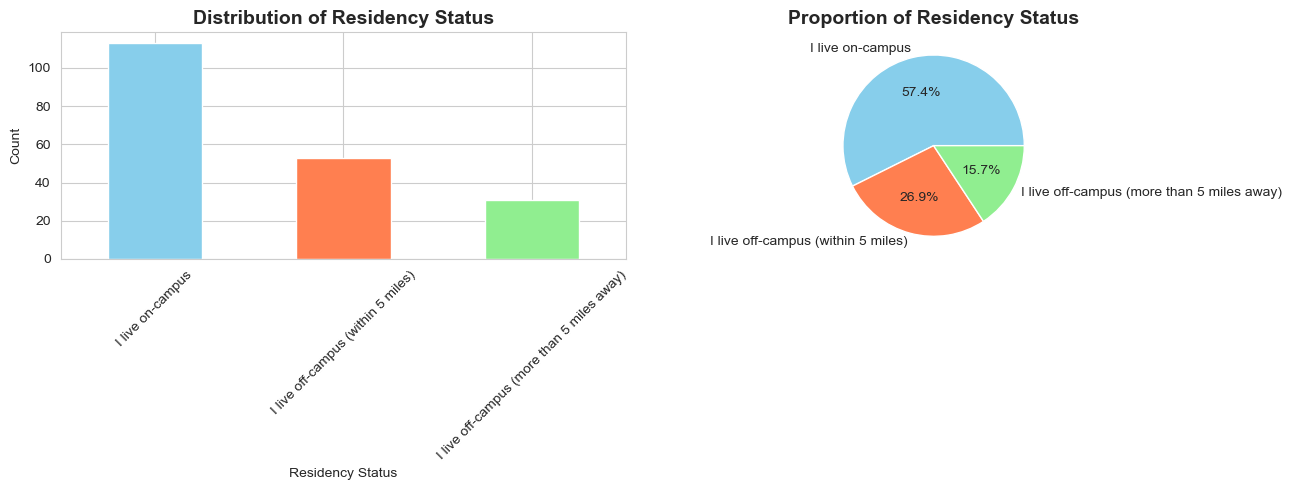

In [3]:
# Analyze target variable distribution
target_col = 'Do you live on-campus or off-campus?'

print("Target Variable Distribution (Residency Status)")
print(data_raw[target_col].value_counts())
print("\nProportions:")
print(data_raw[target_col].value_counts(normalize=True))

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
data_raw[target_col].value_counts().plot(kind='bar', ax=ax[0], color=['skyblue', 'coral', 'lightgreen'])
ax[0].set_title('Distribution of Residency Status', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Residency Status')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

# Pie chart
data_raw[target_col].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         colors=['skyblue', 'coral', 'lightgreen'])
ax[1].set_title('Proportion of Residency Status', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

---
## 2. Data Cleaning and Preprocessing <a id='section2'></a>


In [4]:
df = pd.read_csv('data_cleaned.csv')

print("Cleaned Data Shape:", df.shape)
print(f"\nColumns increased from {data_raw.shape[1]} to {df.shape[1]}")
print(f"New features created: {df.shape[1] - data_raw.shape[1]}")

df['housing_binary'] = df['housing'].apply(lambda x: 1 if 'on-campus' in str(x).lower() else 0)

print("Binary Target Variable")
print("1 = On-Campus, 0 = Off-Campus")
print(df['housing_binary'].value_counts())
print(f"\nClass Balance: {df['housing_binary'].mean():.2%} on-campus")

Cleaned Data Shape: (197, 185)

Columns increased from 19 to 185
New features created: 166
Binary Target Variable
1 = On-Campus, 0 = Off-Campus
housing_binary
1    113
0     84
Name: count, dtype: int64

Class Balance: 57.36% on-campus


In [5]:
feature_cols = []

for col in df.columns:
    if any(keyword in col for keyword in [
        '_encoded', '_tfidf_',
        'delivered_items_', 'order_reasons_',
        'instore_items_', 'communication_methods_',
        'shopping_interests_', 'delivery_method_'
    ]):
        if 'housing' not in col:
            feature_cols.append(col)

print(f"Selected {len(feature_cols)} features for modeling")
print("\nFeature types:")
print(f"  - Encoded: {len([c for c in feature_cols if '_encoded' in c])}")
print(f"  - One-hot: {len([c for c in feature_cols if any(p in c for p in ['delivered_items_', 'order_reasons_'])])}")
print(f"  - TF-IDF: {len([c for c in feature_cols if '_tfidf_' in c])}")

# Prepare feature matrix and target
X = df[feature_cols].fillna(0)
y = df['housing_binary']

print(f"\nFinal dataset: X={X.shape}, y={y.shape}")

Selected 160 features for modeling

Feature types:
  - Encoded: 3
  - One-hot: 40
  - TF-IDF: 82

Final dataset: X=(197, 160), y=(197,)


---
## 3. Exploratory Data Analysis (EDA) <a id='section3'></a>


In [6]:
# Basic statistics
print("Descriptive Statistics")

on_campus = df[df['housing_binary'] == 1]
off_campus = df[df['housing_binary'] == 0]

print(f"\nSample sizes:")
print(f"  On-Campus: {len(on_campus)} ({len(on_campus)/len(df)*100:.1f}%)")
print(f"  Off-Campus: {len(off_campus)} ({len(off_campus)/len(df)*100:.1f}%)")

# Compare key variables
if 'packages_per_week' in df.columns:
    print("Package Delivery Frequency:")
    print("\nOn-Campus:")
    print(on_campus['packages_per_week'].value_counts().head())
    print("\nOff-Campus:")
    print(off_campus['packages_per_week'].value_counts().head())

if 'store_preference' in df.columns:
    print("Store Preference:")
    print("\nOn-Campus:")
    print(on_campus['store_preference'].value_counts())
    print("\nOff-Campus:")
    print(off_campus['store_preference'].value_counts())

Descriptive Statistics

Sample sizes:
  On-Campus: 113 (57.4%)
  Off-Campus: 84 (42.6%)
Package Delivery Frequency:

On-Campus:
packages_per_week
<1                                                        79
1                                                         23
2                                                          5
I have never ordered an item to be delivered to campus     4
4 or more                                                  2
Name: count, dtype: int64

Off-Campus:
packages_per_week
<1                                                        36
I have never ordered an item to be delivered to campus    35
2                                                          6
1                                                          5
3                                                          2
Name: count, dtype: int64
Store Preference:

On-Campus:
store_preference
I buy about the same amount from on- and off-campus stores    39
I buy from more off-campus stores                

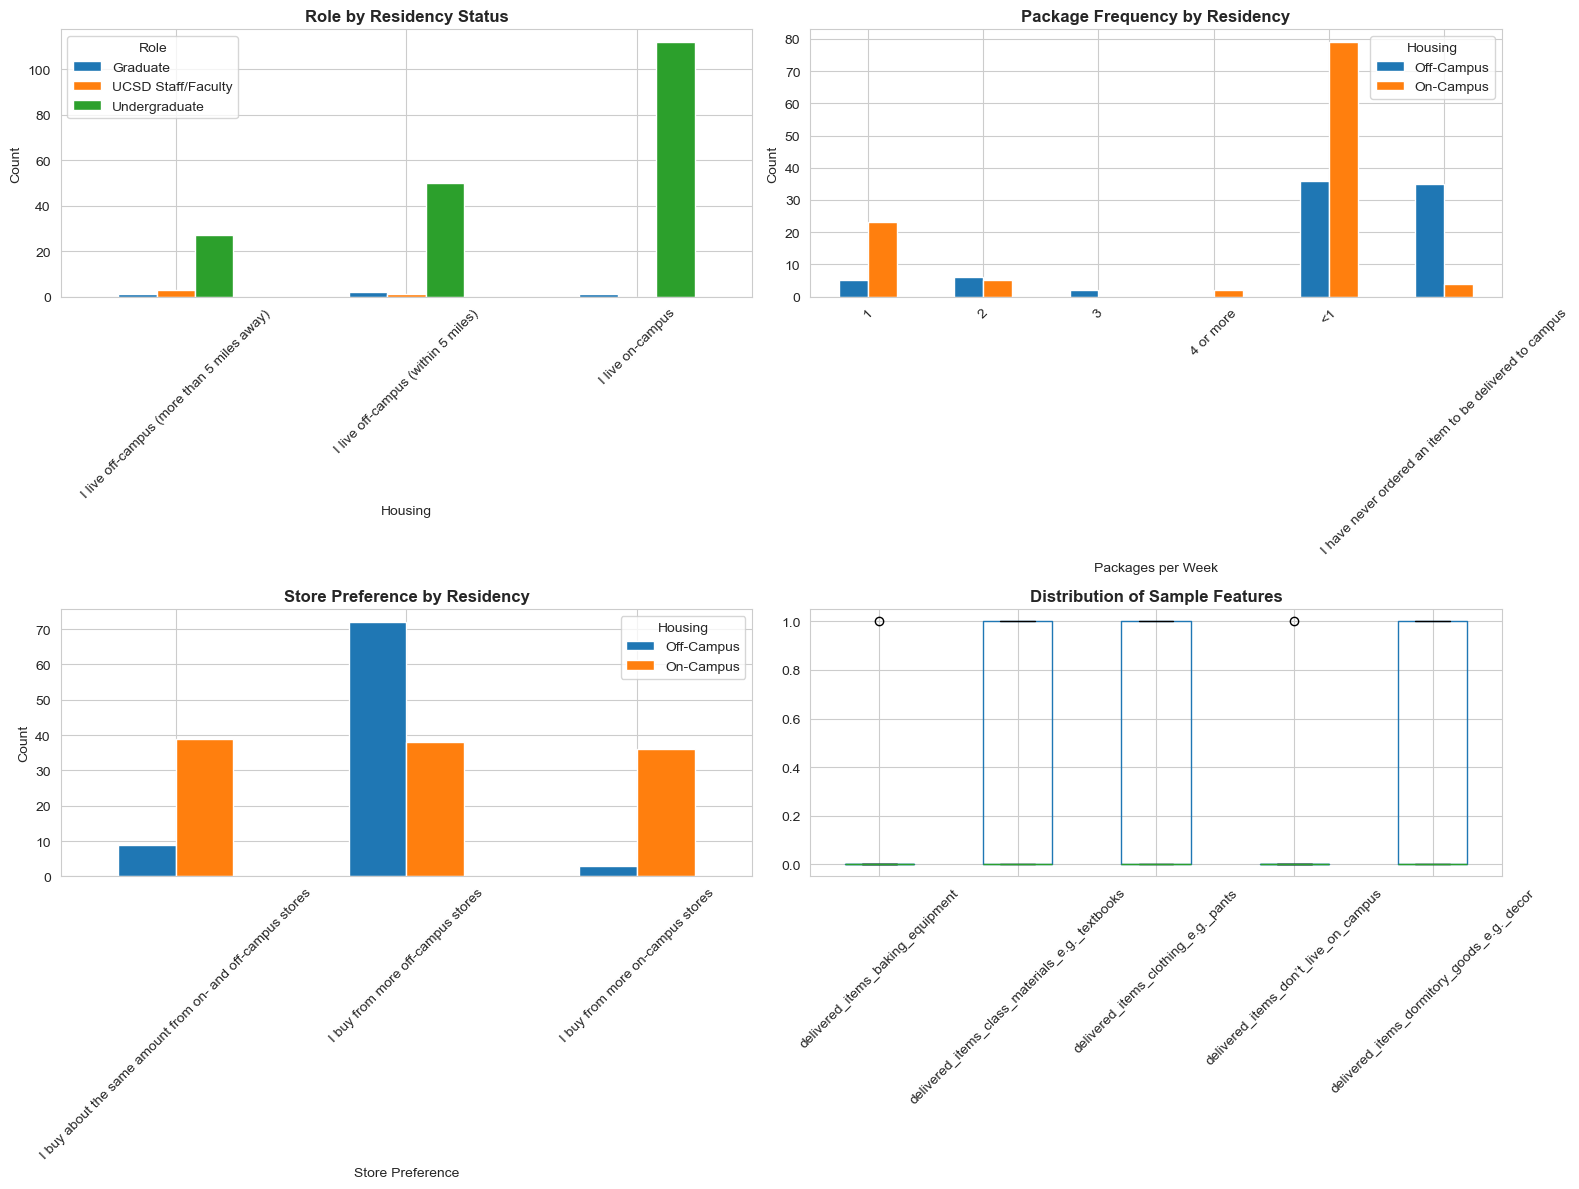

In [7]:
# Visualize key differences
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Role distribution by housing
if 'role' in df.columns:
    pd.crosstab(df['housing'], df['role']).plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Role by Residency Status', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Housing')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend(title='Role')

# 2. Package frequency by housing
if 'packages_per_week' in df.columns:
    pd.crosstab(df['housing_binary'], df['packages_per_week']).T.plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Package Frequency by Residency', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Packages per Week')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Off-Campus', 'On-Campus'], title='Housing')

# 3. Store preference by housing
if 'store_preference' in df.columns:
    pd.crosstab(df['housing_binary'], df['store_preference']).T.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Store Preference by Residency', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Store Preference')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend(['Off-Campus', 'On-Campus'], title='Housing')

# 4. Feature distribution (sample of numeric features)
numeric_sample = X.iloc[:, :5]
numeric_sample.boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Sample Features', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## 4. Feature Relationships and Correlation Analysis <a id='section4'></a>


In [8]:
# Calculate correlation matrix

correlation_matrix = X.corr()

# Find highly correlated features
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"Highly Correlated Features (|r| >{high_corr_threshold})")
print(f"Found {len(high_corr_pairs)} pairs of highly correlated features\n")

if len(high_corr_pairs) > 0:
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show first 10
        print(f"{feat1[:40]:40s} <-> {feat2[:40]:40s} : {corr:.3f}")
    if len(high_corr_pairs) > 10:
        print(f"\n... and {len(high_corr_pairs) - 10} more pairs")

Highly Correlated Features (|r| >0.8)
Found 25 pairs of highly correlated features

delivered_items_class_materials_e.g._tex <-> delivered_items_notebooks                : 1.000
delivered_items_clothing_e.g._pants      <-> delivered_items_shoes                    : 1.000
delivered_items_dormitory_goods_e.g._dec <-> delivered_items_cups_plates              : 1.000
delivered_items_electronics_e.g._tablet  <-> delivered_items_headphones               : 1.000
delivered_items_food_groceries_e.g._past <-> delivered_items_snack_foods              : 1.000
delivered_items_gifted_items_from_family <-> delivered_items_friends                  : 1.000
delivered_items_lab_materials_e.g._glove <-> delivered_items_hardware                 : 0.961
delivered_items_magazines                <-> most_delivered_cleaned_tfidf_socks       : 0.833
delivered_items_mobility_items_e.g._scoo <-> delivered_items_helmet                   : 1.000
delivered_items_personal_care_goods_e.g. <-> delivered_items_deodorant

Correlation With Target Variable

Top 15 features most correlated with residency status:
delivered_items_etc.                                                                0.503508
order_reasons_transportation_issues_ex._limited_no_access_to_a_car                  0.394715
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors    0.312304
delivered_items_friends                                                             0.296970
delivered_items_gifted_items_from_family                                            0.296970
delivered_items_clothing_e.g._pants                                                 0.263568
delivered_items_shoes                                                               0.263568
delivered_items_deodorant                                                           0.253234
delivered_items_personal_care_goods_e.g._toothpaste                                 0.253234
delivered_items_cups_plates                                               

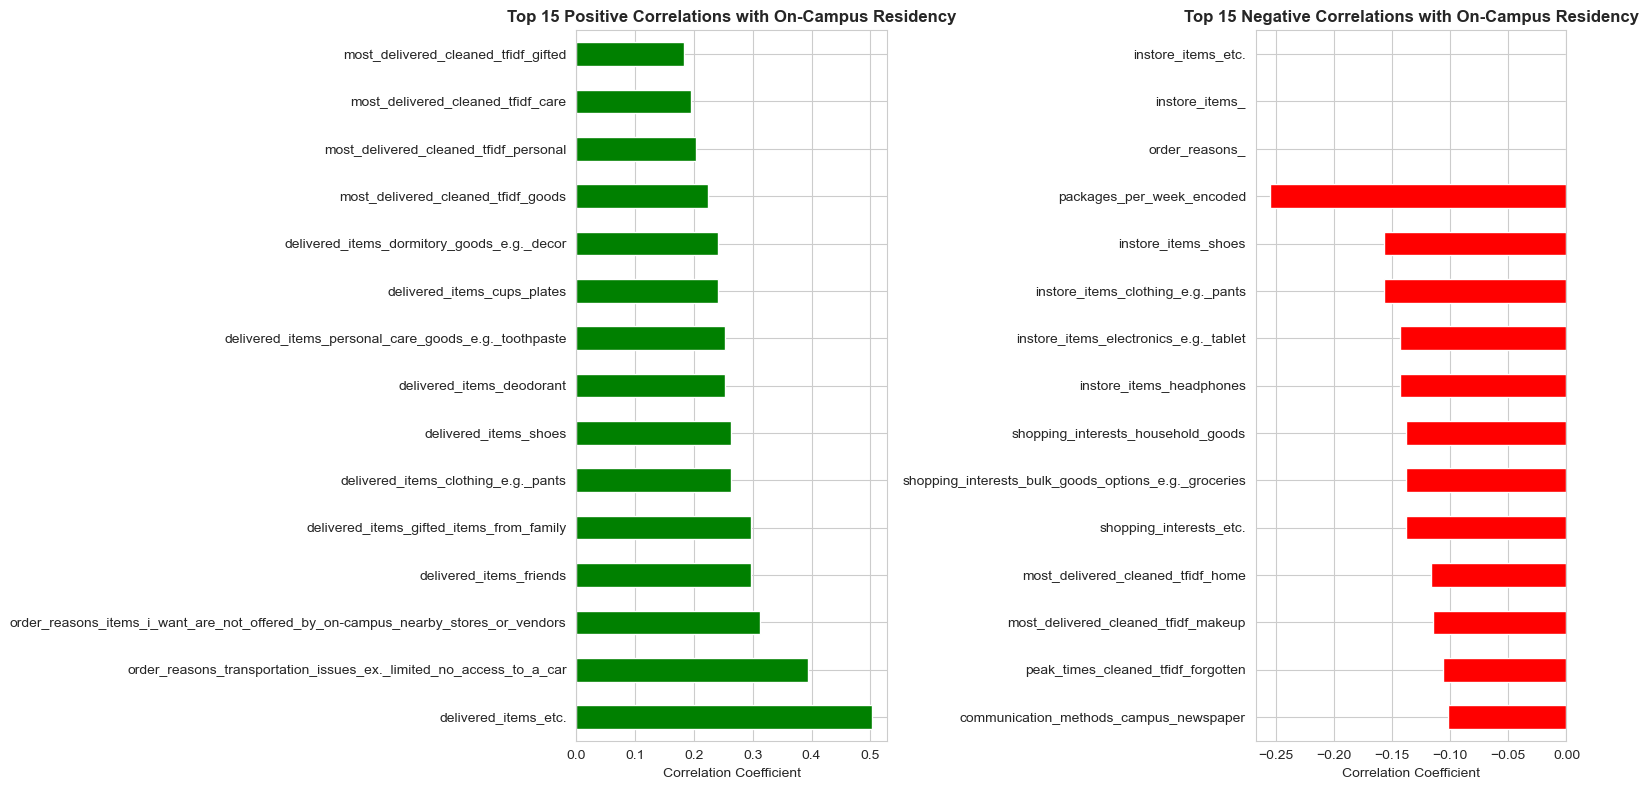

In [9]:
# Visualize correlation with target
print("Correlation With Target Variable")

# Add target to calculate correlations
X_with_target = X.copy()
X_with_target['target'] = y

# Get correlations with target
target_corr = X_with_target.corr()['target'].sort_values(ascending=False)
target_corr = target_corr.drop('target')  # Remove self-correlation

print("\nTop 15 features most correlated with residency status:")
print(target_corr.head(15))

print("\nBottom 15 features (negatively correlated):")
print(target_corr.tail(15))

# Plot top correlations
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Positive correlations
target_corr.head(15).plot(kind='barh', ax=ax[0], color='green')
ax[0].set_title('Top 15 Positive Correlations with On-Campus Residency', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Correlation Coefficient')

# Negative correlations
target_corr.tail(15).plot(kind='barh', ax=ax[1], color='red')
ax[1].set_title('Top 15 Negative Correlations with On-Campus Residency', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

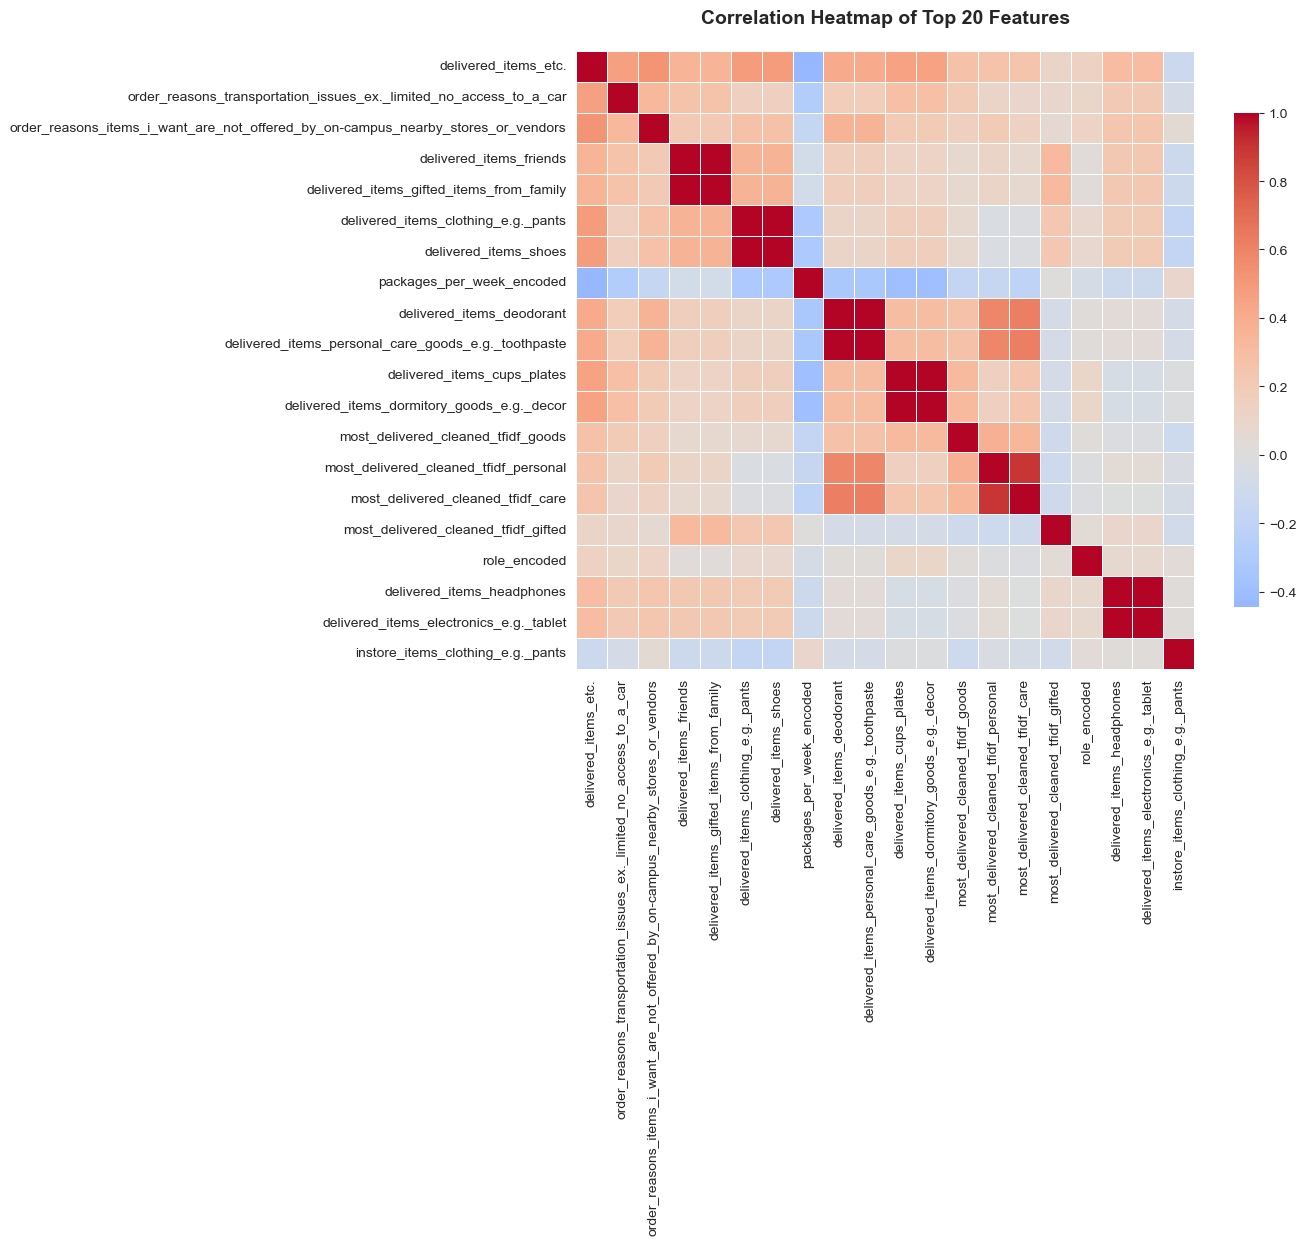

In [10]:
# Heatmap of top features
top_features = abs(target_corr).nlargest(20).index.tolist()
top_corr_matrix = X[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(top_corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Top 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## 5. Multicollinearity Analysis (VIF) <a id='section5'></a>


Variance Inflation Factor (VIF) Analysis

Calculating VIF for all 160 features...
This may take a few moments...

VIF Calculation Complete

VIF Analysis Summary:
  Threshold: 10
  Total features: 160
  Features with infinite VIF: 40
  Features to remove (VIF >= 10): 76
  Features to keep (VIF < 10): 84

Top 30 Features by VIF:
                                                        Feature  VIF
                 delivered_items_class_materials_e.g._textbooks  inf
                            delivered_items_clothing_e.g._pants  inf
                        delivered_items_electronics_e.g._tablet  inf
                     delivered_items_dormitory_goods_e.g._decor  inf
                      delivered_items_food_groceries_e.g._pasta  inf
                       delivered_items_gifted_items_from_family  inf
                    delivered_items_mobility_items_e.g._scooter  inf
                      delivered_items_lab_materials_e.g._gloves  inf
            delivered_items_personal_care_goods_e.

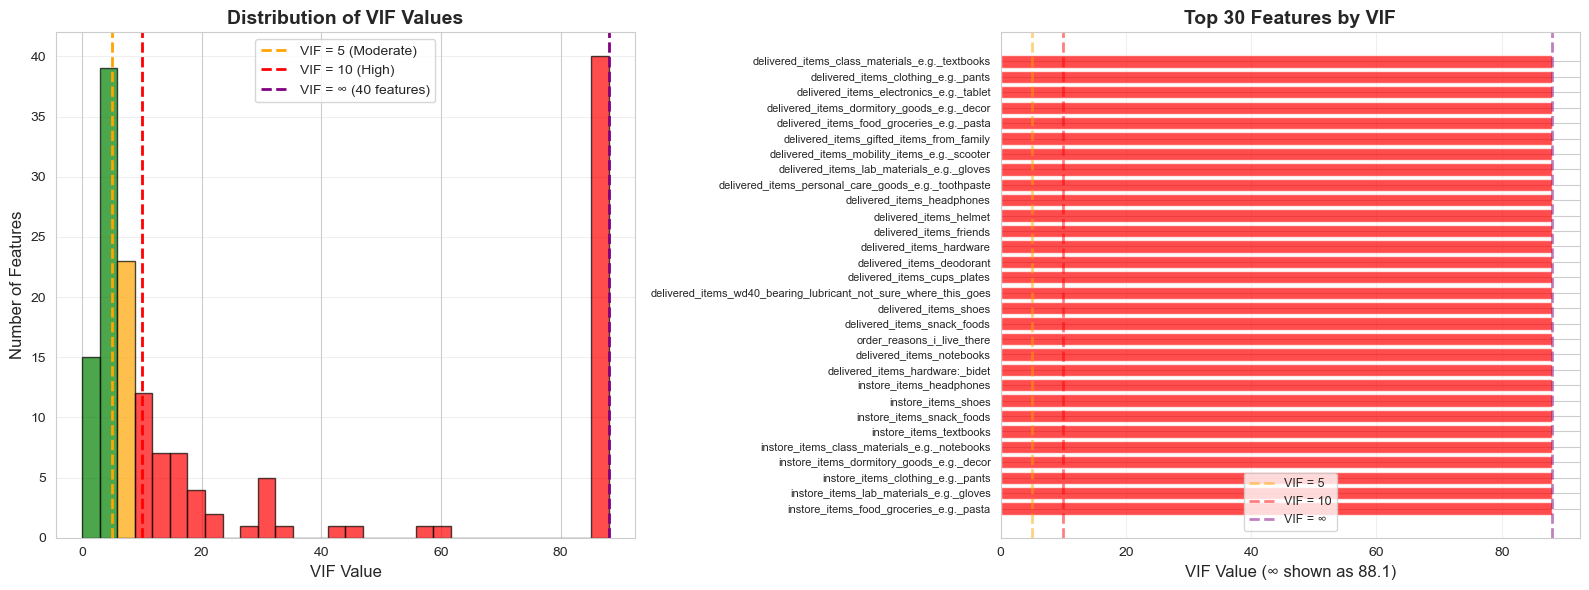


VIF Distribution:
  VIF < 5 (Low multicollinearity): 43 features
  5 <= VIF < 10 (Moderate): 41 features
  10 <= VIF < inf (High): 36 features
  VIF = inf (Perfect multicollinearity): 40 features


In [11]:
# Calculate VIF for ALL features
print("Variance Inflation Factor (VIF) Analysis")

print(f"\nCalculating VIF for all {X.shape[1]} features...")
print("This may take a few moments...")

# Calculate VIF for all features
vif_all = pd.DataFrame()
vif_all['Feature'] = X.columns
vif_all['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_all = vif_all.sort_values('VIF', ascending=False)

print("\nVIF Calculation Complete")

# Define threshold and feature lists for later use
vif_threshold = 10
features_to_remove = vif_all[vif_all['VIF'] >= vif_threshold]['Feature'].tolist()
features_to_keep = vif_all[vif_all['VIF'] < vif_threshold]['Feature'].tolist()

print(f"\nVIF Analysis Summary:")
print(f"  Threshold: {vif_threshold}")
print(f"  Total features: {len(vif_all)}")
print(f"  Features with infinite VIF: {len(vif_all[np.isinf(vif_all['VIF'])])}")
print(f"  Features to remove (VIF >= {vif_threshold}): {len(features_to_remove)}")
print(f"  Features to keep (VIF < {vif_threshold}): {len(features_to_keep)}")

# Create a copy of VIF values, replacing infinity with a large number for visualization
vif_all_display = vif_all.copy()
max_finite_vif = vif_all_display[~np.isinf(vif_all_display['VIF'])]['VIF'].max()
# Replace inf with 1.5x the max finite VIF for visualization purposes
vif_cap = max_finite_vif * 1.5
vif_all_display['VIF_display'] = vif_all_display['VIF'].replace([np.inf], vif_cap)

# Show top 30 features by VIF
print(f"\nTop 30 Features by VIF:")
print(vif_all.head(30).to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram/Distribution of VIF values
ax1 = axes[0]
vif_values = vif_all_display['VIF_display']
counts, bins, patches = ax1.hist(vif_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')

# Color code the bars
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center < 5:
        patch.set_facecolor('green')
        patch.set_alpha(0.7)
    elif bin_center < 10:
        patch.set_facecolor('orange')
        patch.set_alpha(0.7)
    else:
        patch.set_facecolor('red')
        patch.set_alpha(0.7)

ax1.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Moderate)')
ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (High)')
if len(vif_all[np.isinf(vif_all['VIF'])]) > 0:
    ax1.axvline(x=vif_cap, color='purple', linestyle='--', linewidth=2, 
                label=f'VIF = ∞ ({len(vif_all[np.isinf(vif_all["VIF"])])} features)')
ax1.set_xlabel('VIF Value', fontsize=12)
ax1.set_ylabel('Number of Features', fontsize=12)
ax1.set_title('Distribution of VIF Values', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Top 30 features bar chart
ax2 = axes[1]
top_30 = vif_all_display.head(30)
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' for x in top_30['VIF_display']]
y_pos = range(len(top_30))
ax2.barh(y_pos, top_30['VIF_display'], color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_30['Feature'], fontsize=8)
ax2.axvline(x=5, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='VIF = 5')
ax2.axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='VIF = 10')
if len(vif_all[np.isinf(vif_all['VIF'])]) > 0:
    ax2.axvline(x=vif_cap, color='purple', linestyle='--', linewidth=2, alpha=0.5, label='VIF = ∞')
ax2.set_xlabel('VIF Value (∞ shown as {:.1f})'.format(vif_cap), fontsize=12)
ax2.set_title('Top 30 Features by VIF', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Show distribution of VIF values
print("\nVIF Distribution:")
print(f"  VIF < 5 (Low multicollinearity): {len(vif_all[vif_all['VIF'] < 5])} features")
print(f"  5 <= VIF < 10 (Moderate): {len(vif_all[(vif_all['VIF'] >= 5) & (vif_all['VIF'] < 10)])} features")
print(f"  10 <= VIF < inf (High): {len(vif_all[(vif_all['VIF'] >= 10) & ~np.isinf(vif_all['VIF'])])} features")
print(f"  VIF = inf (Perfect multicollinearity): {len(vif_all[np.isinf(vif_all['VIF'])])} features")

---
## 6. Principal Component Analysis (PCA) <a id='section6'></a>


In [12]:
print("Principal Component Analysis")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(random_state=40)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"\nExplained variance by components:")
print(f"  First 5 components: {cumsum_var[4]:.2%}")
print(f"  First 10 components: {cumsum_var[9]:.2%}")
print(f"  First 20 components: {cumsum_var[19]:.2%}")
print(f"  First 50 components: {cumsum_var[49]:.2%}")

# Find number of components for 90% variance
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

Principal Component Analysis

Original number of features: 160

Explained variance by components:
  First 5 components: 16.82%
  First 10 components: 27.92%
  First 20 components: 45.03%
  First 50 components: 77.02%

Components needed for 90% variance: 73
Components needed for 95% variance: 87


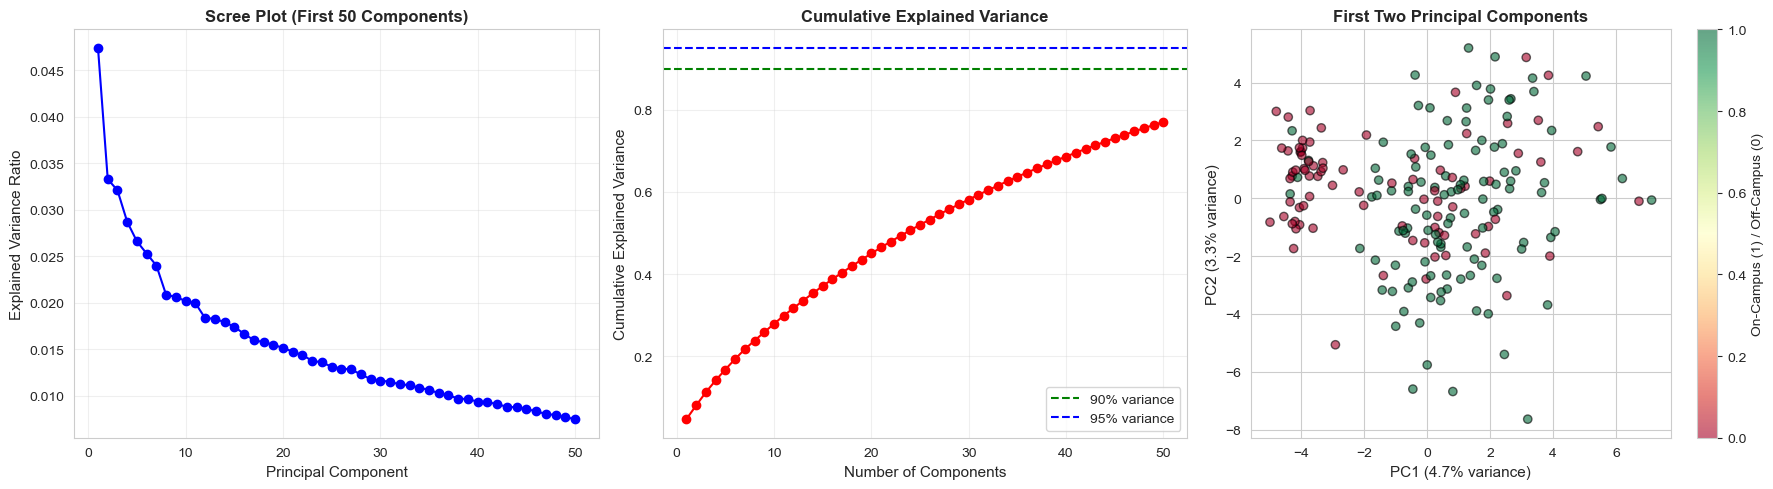

In [13]:
# Visualize PCA results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scree plot
axes[0].plot(range(1, min(51, len(pca.explained_variance_ratio_)+1)), 
             pca.explained_variance_ratio_[:50], 'bo-')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Scree Plot (First 50 Components)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Cumulative variance
axes[1].plot(range(1, min(51, len(cumsum_var)+1)), cumsum_var[:50], 'ro-')
axes[1].axhline(y=0.90, color='green', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='blue', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 2D visualization of first 2 PCs
scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlGn', alpha=0.6, edgecolors='k')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[2].set_title('First Two Principal Components', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[2], label='On-Campus (1) / Off-Campus (0)')

plt.tight_layout()
plt.show()

---
## 7. Hypothesis Testing <a id='section7'></a>


In [14]:
print("Hypothesis Testing: Numeric Features (Mann-Whitney U Test)")

# Test top 20 features most correlated with target
test_features = abs(target_corr).nlargest(20).index.tolist()
mann_whitney_results = []

for feature in test_features[:10]:
    on_campus_vals = X[feature][y == 1]
    off_campus_vals = X[feature][y == 0]
    
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(on_campus_vals, off_campus_vals, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U-Statistic': statistic,
        'p-value': p_value,
        'On-Campus Mean': on_campus_vals.mean(),
        'Off-Campus Mean': off_campus_vals.mean(),
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Display results
mann_df = pd.DataFrame(mann_whitney_results)
print(mann_df.to_string(index=False))

print(f"Significant features (p < 0.05): {len(mann_df[mann_df['Significant'] == 'Yes'])} out of {len(mann_df)}")

Hypothesis Testing: Numeric Features (Mann-Whitney U Test)
                                                                         Feature  U-Statistic      p-value  On-Campus Mean  Off-Campus Mean Significant
                                                            delivered_items_etc.       6725.0 1.823809e-12        0.964602         0.547619         Yes
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car       6627.0 3.303401e-08        0.610619         0.214286         Yes
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors       6244.5 1.237955e-05        0.637168         0.321429         Yes
                                                         delivered_items_friends       6069.5 3.238578e-05        0.433628         0.154762         Yes
                                        delivered_items_gifted_items_from_family       6069.5 3.238578e-05        0.433628         0.154762         Yes
                             

## Research Question 1
**Can we predict whether a student lives on-campus or off-campus based on their shopping and package delivery behaviors?**

---
## 8. Logistic Regression - Assumptions and Modeling <a id='section8'></a>


In [15]:
print("Logistic Regression Modeling")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=40
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in train set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())

Logistic Regression Modeling

Train set: 157 samples
Test set: 40 samples

Class distribution in train set:
housing_binary
1    90
0    67
Name: count, dtype: int64

Class distribution in test set:
housing_binary
1    23
0    17
Name: count, dtype: int64


In [16]:
# Train basic logistic regression
print("Training Logistic Regression (Basic)")

lr_basic = LogisticRegression(max_iter=1000, random_state=40)
lr_basic.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_basic.predict(X_test)
y_pred_proba_lr = lr_basic.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\nTest Accuracy: {accuracy_lr:.3f}")
print(f"ROC AUC Score: {auc_lr:.3f}")

# Cross-validation
cv_scores_lr = cross_val_score(lr_basic, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std():.3f})")

print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Off-Campus', 'On-Campus']))

Training Logistic Regression (Basic)

Test Accuracy: 0.700
ROC AUC Score: 0.685

Cross-Validation Accuracy: 0.644 (+/- 0.112)
Classification Report:
              precision    recall  f1-score   support

  Off-Campus       0.67      0.59      0.62        17
   On-Campus       0.72      0.78      0.75        23

    accuracy                           0.70        40
   macro avg       0.69      0.69      0.69        40
weighted avg       0.70      0.70      0.70        40



In [17]:
# Train regularized logistic regression (L2 penalty)
print("Training Logistic Regression with L2 Regularization")

# Grid search for best C parameter
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=40),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print(f"\nBest C parameter: {grid_lr.best_params_['C']}")
print(f"Best CV score: {grid_lr.best_score_:.3f}")

# Best model
lr_best = grid_lr.best_estimator_
y_pred_lr_best = lr_best.predict(X_test)
y_pred_proba_lr_best = lr_best.predict_proba(X_test)[:, 1]

accuracy_lr_best = accuracy_score(y_test, y_pred_lr_best)
auc_lr_best = roc_auc_score(y_test, y_pred_proba_lr_best)

print(f"\nTest Accuracy: {accuracy_lr_best:.3f}")
print(f"ROC AUC Score: {auc_lr_best:.3f}")

Training Logistic Regression with L2 Regularization

Best C parameter: 0.01
Best CV score: 0.726

Test Accuracy: 0.700
ROC AUC Score: 0.765


Logistic Regression Coefficients

Top features increasing likelihood of On-Campus residency:
                                                                         Feature  Coefficient
                                                            delivered_items_etc.     0.111943
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car     0.110352
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors     0.082099
                             delivered_items_personal_care_goods_e.g._toothpaste     0.070948
                                                       delivered_items_deodorant     0.070948
                                             delivered_items_clothing_e.g._pants     0.067572
                                                           delivered_items_shoes     0.067572
                                                         delivered_items_friends     0.065379
                                        delivered_items_gifte

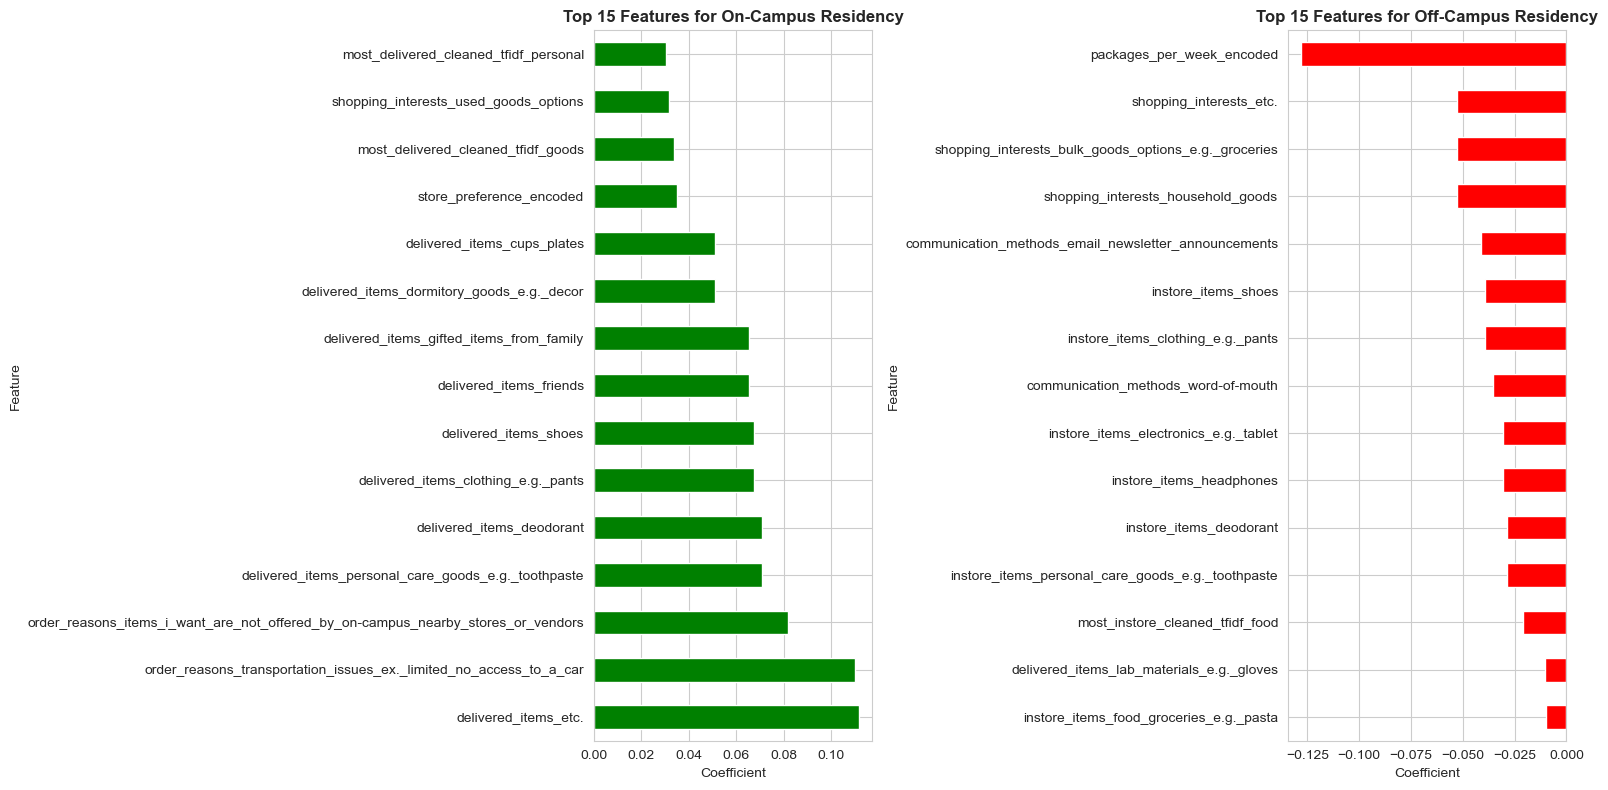

In [18]:
# Analyze coefficients
print("Logistic Regression Coefficients")
print("\nTop features increasing likelihood of On-Campus residency:")

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_best.coef_[0]
}).sort_values('Coefficient', ascending=False)

print(coef_df.head(15).to_string(index=False))

print("Top features increasing likelihood of Off-Campus residency:")
print(coef_df.tail(15).to_string(index=False))

# Visualize top coefficients
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

coef_df.head(15).plot(x='Feature', y='Coefficient', kind='barh', ax=ax[0], color='green', legend=False)
ax[0].set_title('Top 15 Features for On-Campus Residency', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Coefficient')

coef_df.tail(15).plot(x='Feature', y='Coefficient', kind='barh', ax=ax[1], color='red', legend=False)
ax[1].set_title('Top 15 Features for Off-Campus Residency', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()

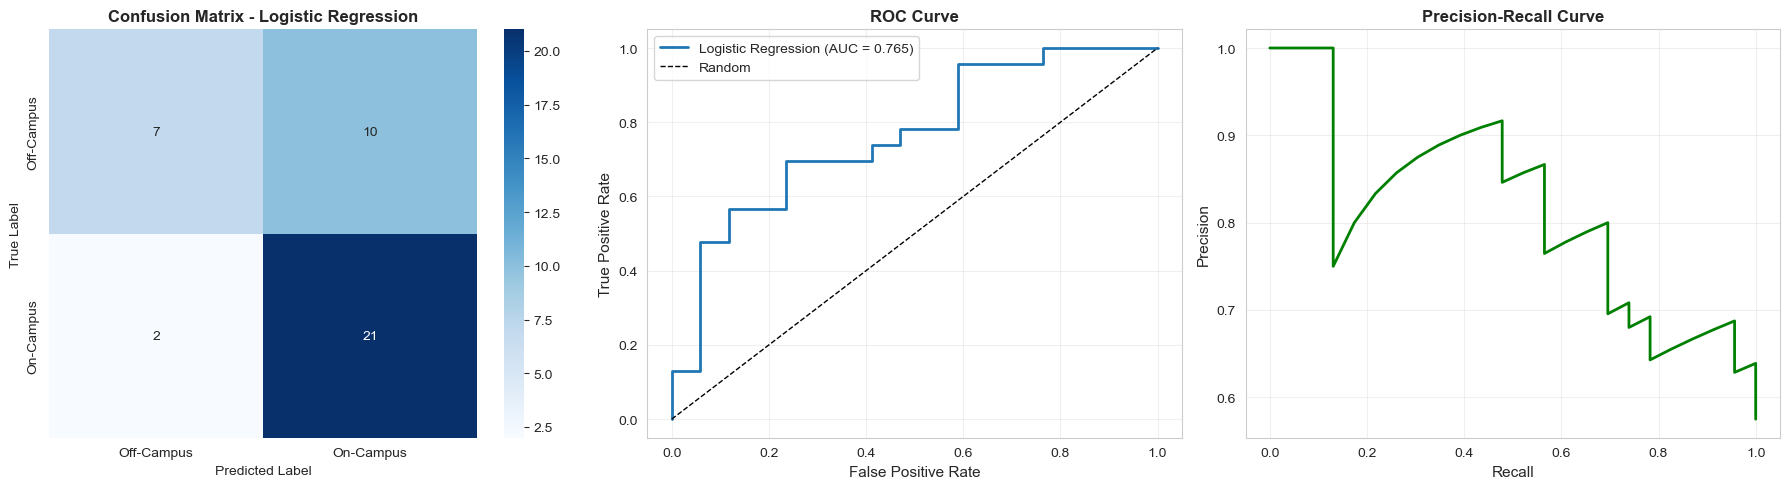

In [19]:
# Visualize logistic regression results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr_best)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# 2. ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr_best)
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr_best:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr_best)
axes[2].plot(recall_lr, precision_lr, linewidth=2, color='green')
axes[2].set_xlabel('Recall', fontsize=11)
axes[2].set_ylabel('Precision', fontsize=11)
axes[2].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Random Forest Modeling <a id='section9'></a>


In [20]:
print("Random Forest Modeling")

# Train basic Random Forest
print("Training Random Forest (Basic)")

rf_basic = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=40
)
rf_basic.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_basic.predict(X_test)
y_pred_proba_rf = rf_basic.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nTest Accuracy: {accuracy_rf:.3f}")
print(f"ROC AUC Score: {auc_rf:.3f}")

# Cross-validation
cv_scores_rf = cross_val_score(rf_basic, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std():.3f})")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Off-Campus', 'On-Campus']))

Random Forest Modeling
Training Random Forest (Basic)

Test Accuracy: 0.675
ROC AUC Score: 0.754

Cross-Validation Accuracy: 0.720 (+/- 0.035)
Classification Report:
              precision    recall  f1-score   support

  Off-Campus       0.67      0.47      0.55        17
   On-Campus       0.68      0.83      0.75        23

    accuracy                           0.68        40
   macro avg       0.67      0.65      0.65        40
weighted avg       0.67      0.68      0.66        40



In [21]:
# Hyperparameter tuning
print("Hyperparameter Tuning with Grid Search")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=40),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print(f"\nBest parameters: {grid_rf.best_params_}")
print(f"Best CV score: {grid_rf.best_score_:.3f}")

# Best model
rf_best = grid_rf.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)
y_pred_proba_rf_best = rf_best.predict_proba(X_test)[:, 1]

accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
auc_rf_best = roc_auc_score(y_test, y_pred_proba_rf_best)

print(f"\nTest Accuracy: {accuracy_rf_best:.3f}")
print(f"ROC AUC Score: {auc_rf_best:.3f}")

Hyperparameter Tuning with Grid Search
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.751

Test Accuracy: 0.750
ROC AUC Score: 0.749


Random Forest Feature Importance

Top 20 Most Important Features:
                                                                         Feature  Importance
                                                       packages_per_week_encoded    0.062198
                                                            delivered_items_etc.    0.055595
                                                        store_preference_encoded    0.044147
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car    0.041848
                                              most_delivered_cleaned_tfidf_goods    0.029755
                                           most_delivered_cleaned_tfidf_personal    0.027928
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors    0.027632
                                             delivered_items_clothing_e.g._pants    0.026227
                                        delivered_items_gifted_items_from_family    0.022343
    

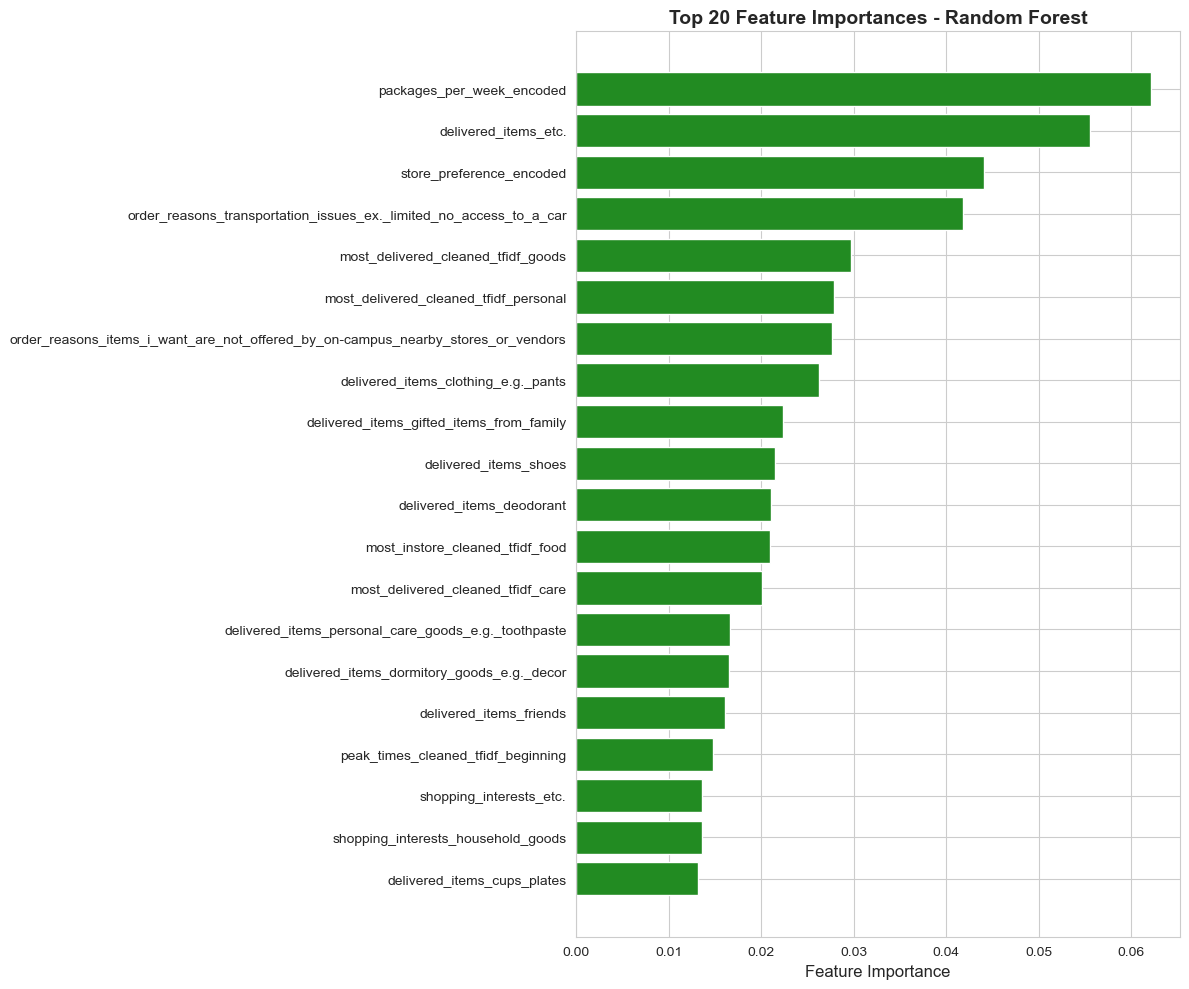

In [22]:
# Feature importance analysis
print("Random Forest Feature Importance")

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 10))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='forestgreen')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

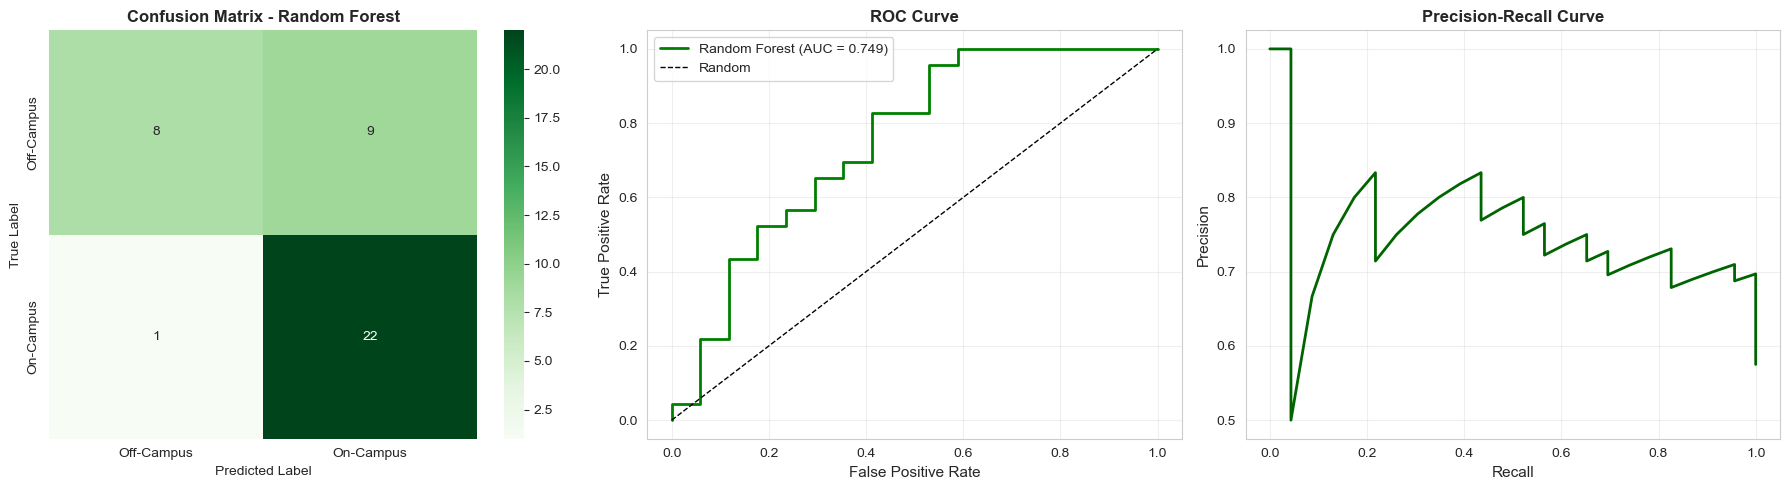

In [23]:
# Visualize Random Forest results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_best)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# 2. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_best)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf_best:.3f})', linewidth=2, color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf_best)
axes[2].plot(recall_rf, precision_rf, linewidth=2, color='darkgreen')
axes[2].set_xlabel('Recall', fontsize=11)
axes[2].set_ylabel('Precision', fontsize=11)
axes[2].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 10. Model Comparison and Conclusions <a id='section10'></a>


In [24]:
# Compare all models
print("Model Comparison")

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression (Basic)', 'Logistic Regression (Tuned)', 
              'Random Forest (Basic)', 'Random Forest (Tuned)'],
    'Test Accuracy': [accuracy_lr, accuracy_lr_best, accuracy_rf, accuracy_rf_best],
    'ROC AUC': [auc_lr, auc_lr_best, auc_rf, auc_rf_best],
    'CV Accuracy Mean': [cv_scores_lr.mean(), grid_lr.best_score_, 
                         cv_scores_rf.mean(), grid_rf.best_score_],
    'CV Accuracy Std': [cv_scores_lr.std(), np.nan, cv_scores_rf.std(), np.nan]
})

print("\n", comparison_df.to_string(index=False))

# Find best model
best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Test Accuracy']

print(f"Best Model:{best_model_name}")
print(f"Test Accuracy: {best_accuracy:.3f}")

Model Comparison

                       Model  Test Accuracy  ROC AUC  CV Accuracy Mean  CV Accuracy Std
Logistic Regression (Basic)          0.700 0.685422          0.644153         0.112083
Logistic Regression (Tuned)          0.700 0.764706          0.726210              NaN
      Random Forest (Basic)          0.675 0.754476          0.719960         0.034736
      Random Forest (Tuned)          0.750 0.749361          0.751411              NaN
Best Model:Random Forest (Tuned)
Test Accuracy: 0.750


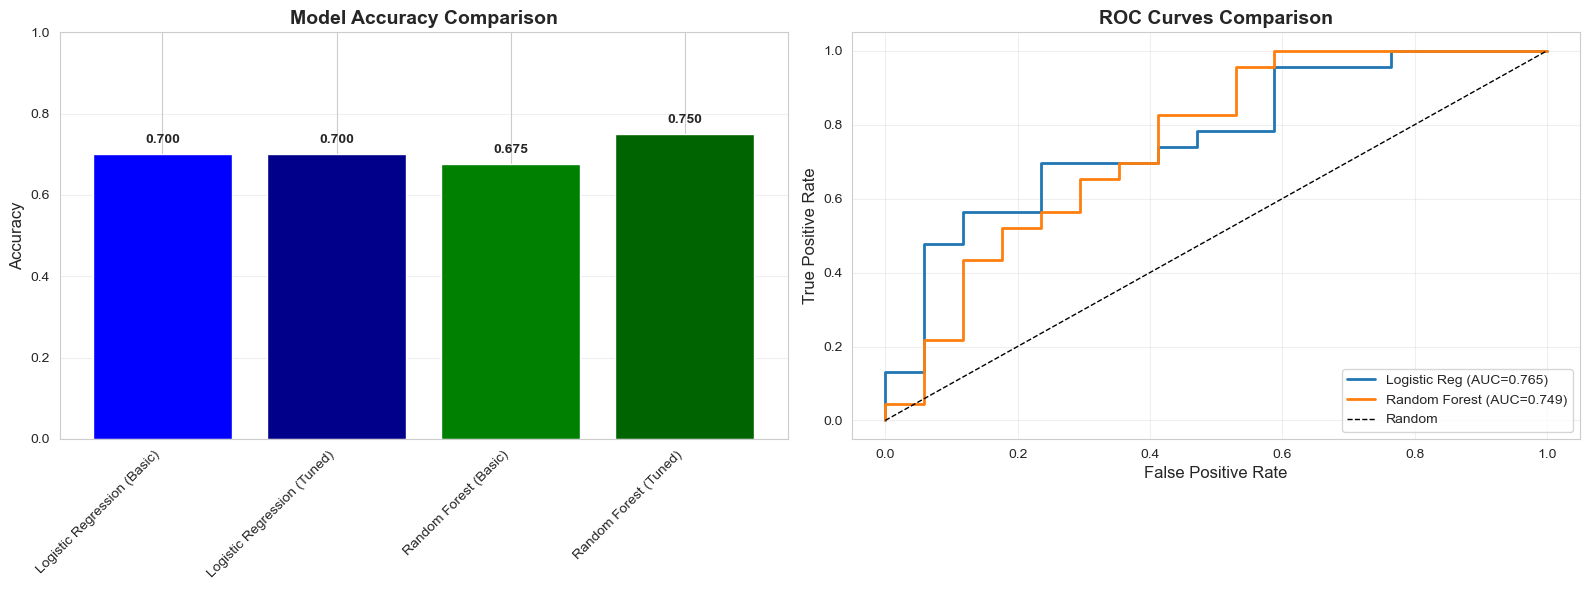

In [25]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos, comparison_df['Test Accuracy'], color=['blue', 'darkblue', 'green', 'darkgreen'])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. ROC curves comparison
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={auc_lr_best:.3f})', linewidth=2)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf_best:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
for i, row in importance_df.head(5).iterrows():
    print(f"   - {row['Feature']}")



   - packages_per_week_encoded
   - delivered_items_etc.
   - store_preference_encoded
   - order_reasons_transportation_issues_ex._limited_no_access_to_a_car
   - most_delivered_cleaned_tfidf_goods


---
## 11. MODELING WITH VIF-REDUCED FEATURES <a id='section12'></a>


In [27]:
# REMOVE HIGH VIF FEATURES

print("Feature Selection: Removing High-VIF Features")

# Use VIF threshold and feature lists defined in Section 5
print(f"\nUsing variables from Section 5 VIF Analysis:")
print(f"  VIF Threshold: {vif_threshold}")
print(f"  Original number of features: {len(X.columns)}")
print(f"  Features to remove (VIF >= {vif_threshold}): {len(features_to_remove)}")
print(f"  Features to keep (VIF < {vif_threshold}): {len(features_to_keep)}")

# Create reduced feature set
X_reduced = X[features_to_keep].copy()

print(f"\nReduced feature set shape: {X_reduced.shape}")

n_events_reduced = min(y.sum(), len(y) - y.sum())

# Split the reduced dataset
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=40
)

print(f"\nReduced train set: {X_train_reduced.shape}")
print(f"Reduced test set: {X_test_reduced.shape}")

# Show which feature categories were most affected
print("\nFeature Types Removed:")

removed_types = {}
for feat in features_to_remove:
    for keyword in ['delivered_items_', 'order_reasons_', 'instore_items_', 
                    'communication_methods_', 'shopping_interests_', '_tfidf_', '_encoded']:
        if keyword in feat:
            key = keyword.replace('_', ' ').strip()
            removed_types[key] = removed_types.get(key, 0) + 1
            break

for ftype, count in sorted(removed_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {ftype}: {count} features")

print("\nFeature Selection Complete")

Feature Selection: Removing High-VIF Features

Using variables from Section 5 VIF Analysis:
  VIF Threshold: 10
  Original number of features: 160
  Features to remove (VIF >= 10): 76
  Features to keep (VIF < 10): 84

Reduced feature set shape: (197, 84)

Reduced train set: (157, 84)
Reduced test set: (40, 84)

Feature Types Removed:
  - tfidf: 32 features
  - delivered items: 24 features
  - instore items: 16 features
  - shopping interests: 3 features
  - order reasons: 1 features

Feature Selection Complete


---
### 11a. Logistic Regression with VIF-Reduced Features

We'll train Logistic Regression using the VIF-reduced feature set (84 features with VIF < 10).

Logistic Regression With Vif-Selected Features

Training logistic regression with 84 features (reduced from 160)

Best C parameter: 0.01
Best CV score: 0.707
Performance Metrics
Test Accuracy: 0.725
ROC AUC Score: 0.683
CV Accuracy: 0.707
CV Accuracy Mean: 0.707 (+/- 0.076)
Classification Report:
              precision    recall  f1-score   support

  Off-Campus       0.88      0.41      0.56        17
   On-Campus       0.69      0.96      0.80        23

    accuracy                           0.72        40
   macro avg       0.78      0.68      0.68        40
weighted avg       0.77      0.72      0.70        40


Confusion Matrix:
[[ 7 10]
 [ 1 22]]
Comparison: Original vs. Vif-Reduced Features

Metric                    Original        VIF-Reduced     Change         
Number of Features        160             84              -76            
Test Accuracy             0.7000          0.7250          +0.0250        
ROC AUC                   0.7647          0.6829          -0.0818   

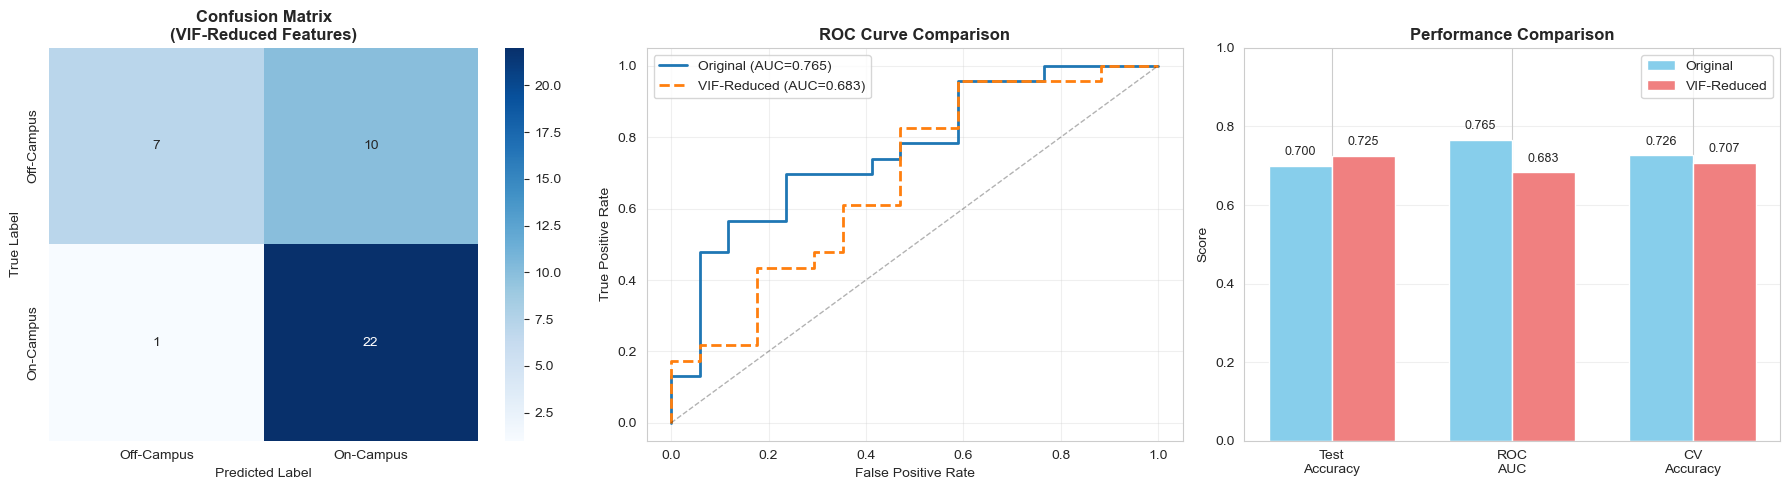

In [28]:
# TRAIN LOGISTIC REGRESSION ON REDUCED FEATURES

print("Logistic Regression With Vif-Selected Features")

print(f"\nTraining logistic regression with {X_reduced.shape[1]} features (reduced from {X.shape[1]})")

# Train logistic regression with grid search

param_grid_reduced = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr_reduced = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=40),
    param_grid_reduced,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_lr_reduced.fit(X_train_reduced, y_train_reduced)

print(f"\nBest C parameter: {grid_lr_reduced.best_params_['C']}")
print(f"Best CV score: {grid_lr_reduced.best_score_:.3f}")

# Best model
lr_reduced = grid_lr_reduced.best_estimator_
y_pred_lr_reduced = lr_reduced.predict(X_test_reduced)
y_pred_proba_lr_reduced = lr_reduced.predict_proba(X_test_reduced)[:, 1]

# Evaluate
accuracy_lr_reduced = accuracy_score(y_test_reduced, y_pred_lr_reduced)
auc_lr_reduced = roc_auc_score(y_test_reduced, y_pred_proba_lr_reduced)

print("Performance Metrics")
print(f"Test Accuracy: {accuracy_lr_reduced:.3f}")
print(f"ROC AUC Score: {auc_lr_reduced:.3f}")
print(f"CV Accuracy: {grid_lr_reduced.best_score_:.3f}")

# Cross-validation scores
cv_scores_lr_reduced = cross_val_score(lr_reduced, X_train_reduced, y_train_reduced, cv=5, scoring='accuracy')
print(f"CV Accuracy Mean: {cv_scores_lr_reduced.mean():.3f} (+/- {cv_scores_lr_reduced.std():.3f})")

print("Classification Report:")
print(classification_report(y_test_reduced, y_pred_lr_reduced, target_names=['Off-Campus', 'On-Campus']))

# Confusion matrix
print("\nConfusion Matrix:")
cm_lr_reduced = confusion_matrix(y_test_reduced, y_pred_lr_reduced)
print(cm_lr_reduced)

# Compare with original
print("Comparison: Original vs. Vif-Reduced Features")
print(f"\n{'Metric':<25} {'Original':<15} {'VIF-Reduced':<15} {'Change':<15}")
print(f"{'Number of Features':<25} {X.shape[1]:<15} {X_reduced.shape[1]:<15} {X_reduced.shape[1] - X.shape[1]:<15}")
print(f"{'Test Accuracy':<25} {accuracy_lr_best:<15.4f} {accuracy_lr_reduced:<15.4f} {accuracy_lr_reduced - accuracy_lr_best:<+15.4f}")
print(f"{'ROC AUC':<25} {auc_lr_best:<15.4f} {auc_lr_reduced:<15.4f} {auc_lr_reduced - auc_lr_best:<+15.4f}")
print(f"{'CV Accuracy':<25} {grid_lr.best_score_:<15.4f} {grid_lr_reduced.best_score_:<15.4f} {grid_lr_reduced.best_score_ - grid_lr.best_score_:<+15.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
sns.heatmap(cm_lr_reduced, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix\n(VIF-Reduced Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# ROC curves comparison
fpr_lr_reduced, tpr_lr_reduced, _ = roc_curve(y_test_reduced, y_pred_proba_lr_reduced)
axes[1].plot(fpr_lr, tpr_lr, label=f'Original (AUC={auc_lr_best:.3f})', linewidth=2)
axes[1].plot(fpr_lr_reduced, tpr_lr_reduced, label=f'VIF-Reduced (AUC={auc_lr_reduced:.3f})', linewidth=2, linestyle='--')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Accuracy comparison
metrics = ['Test\nAccuracy', 'ROC\nAUC', 'CV\nAccuracy']
original_scores = [accuracy_lr_best, auc_lr_best, grid_lr.best_score_]
reduced_scores = [accuracy_lr_reduced, auc_lr_reduced, grid_lr_reduced.best_score_]

x = np.arange(len(metrics))
width = 0.35

axes[2].bar(x - width/2, original_scores, width, label='Original', color='skyblue')
axes[2].bar(x + width/2, reduced_scores, width, label='VIF-Reduced', color='lightcoral')
axes[2].set_ylabel('Score')
axes[2].set_title('Performance Comparison', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics)
axes[2].legend()
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (orig, red) in enumerate(zip(original_scores, reduced_scores)):
    axes[2].text(i - width/2, orig + 0.02, f'{orig:.3f}', ha='center', va='bottom', fontsize=9)
    axes[2].text(i + width/2, red + 0.02, f'{red:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
### 11b. Random Forest with VIF-Reduced Features

Now we'll train Random Forest using the VIF-reduced feature set (84 features with VIF < 10).

In [29]:
# TRAIN RANDOM FOREST ON VIF-REDUCED FEATURES

print("Random Forest with VIF-Reduced Features")

print(f"\nTraining Random Forest with {X_reduced.shape[1]} features (reduced from {X.shape[1]})")

# Grid search for hyperparameter tuning
param_grid_rf_reduced = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf_reduced = GridSearchCV(
    RandomForestClassifier(random_state=40, n_jobs=-1),
    param_grid_rf_reduced,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rf_reduced.fit(X_train_reduced, y_train_reduced)

print(f"\nBest parameters: {grid_rf_reduced.best_params_}")
print(f"Best CV score: {grid_rf_reduced.best_score_:.3f}")

# Best model
rf_reduced = grid_rf_reduced.best_estimator_
y_pred_rf_reduced = rf_reduced.predict(X_test_reduced)
y_pred_proba_rf_reduced = rf_reduced.predict_proba(X_test_reduced)[:, 1]

# Evaluate
accuracy_rf_reduced = accuracy_score(y_test_reduced, y_pred_rf_reduced)
auc_rf_reduced = roc_auc_score(y_test_reduced, y_pred_proba_rf_reduced)
cv_acc_rf_reduced = grid_rf_reduced.best_score_

print("\nPerformance Metrics:")
print(f"Test Accuracy: {accuracy_rf_reduced:.3f}")
print(f"ROC AUC Score: {auc_rf_reduced:.3f}")
print(f"CV Accuracy: {cv_acc_rf_reduced:.3f}")

# Cross-validation scores
cv_scores_rf_reduced = cross_val_score(rf_reduced, X_train_reduced, y_train_reduced, cv=5, scoring='accuracy')
print(f"CV Accuracy Mean: {cv_scores_rf_reduced.mean():.3f} (+/- {cv_scores_rf_reduced.std():.3f})")

print("\nClassification Report:")
print(classification_report(y_test_reduced, y_pred_rf_reduced, target_names=['Off-Campus', 'On-Campus']))

# Confusion matrix
print("\nConfusion Matrix:")
cm_rf_reduced = confusion_matrix(y_test_reduced, y_pred_rf_reduced)
print(cm_rf_reduced)

# Calculate ROC curve data for later visualization
fpr_rf_reduced, tpr_rf_reduced, _ = roc_curve(y_test_reduced, y_pred_proba_rf_reduced)

print("\nRandom Forest VIF-Reduced Training Complete")

Random Forest with VIF-Reduced Features

Training Random Forest with 84 features (reduced from 160)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.783

Performance Metrics:
Test Accuracy: 0.750
ROC AUC Score: 0.780
CV Accuracy: 0.783
CV Accuracy Mean: 0.783 (+/- 0.024)

Classification Report:
              precision    recall  f1-score   support

  Off-Campus       0.77      0.59      0.67        17
   On-Campus       0.74      0.87      0.80        23

    accuracy                           0.75        40
   macro avg       0.75      0.73      0.73        40
weighted avg       0.75      0.75      0.74        40


Confusion Matrix:
[[10  7]
 [ 3 20]]

Random Forest VIF-Reduced Training Complete


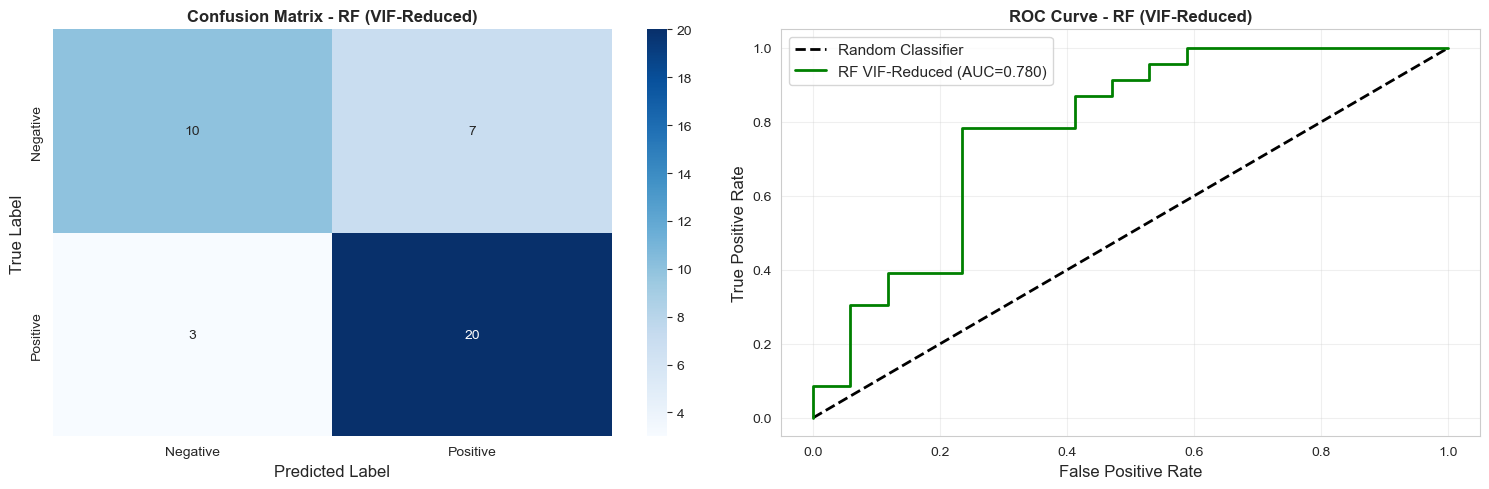

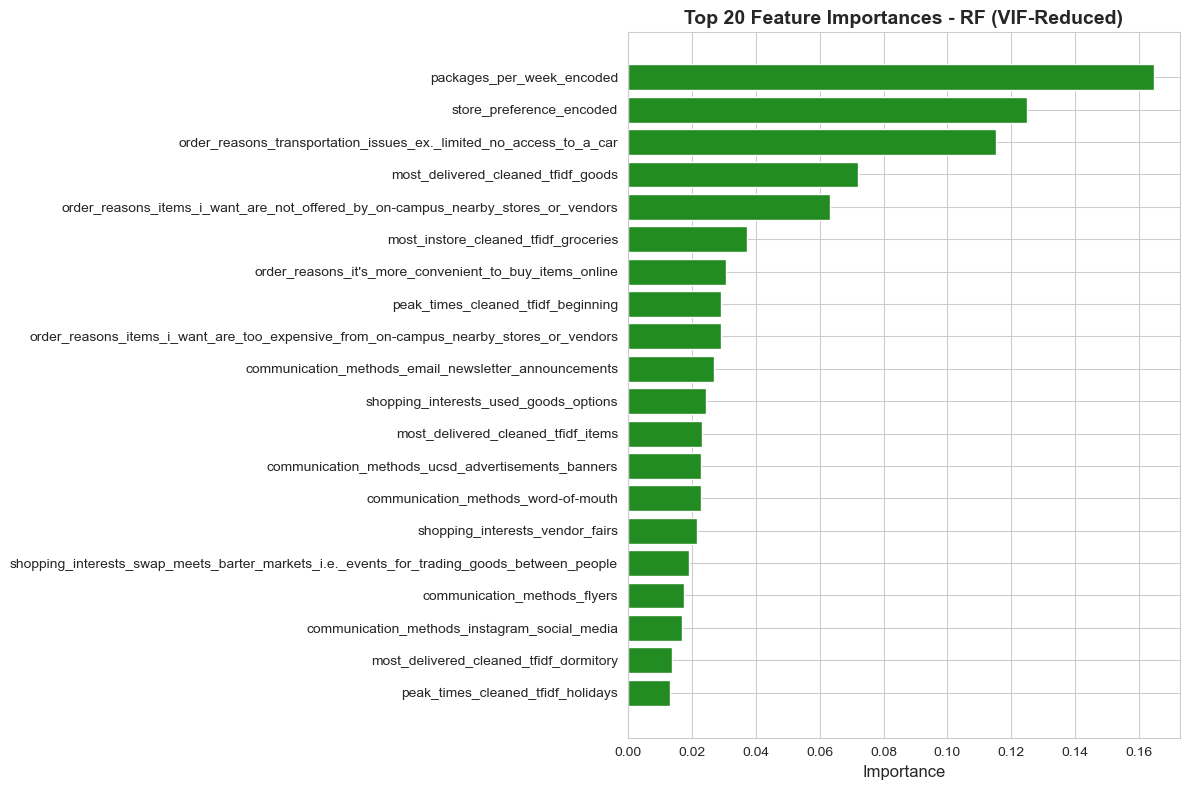

In [30]:
# Visualize Random Forest VIF-Reduced Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
sns.heatmap(cm_rf_reduced, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix - RF (VIF-Reduced)', fontsize=12, fontweight='bold')

# ROC Curve
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[1].plot(fpr_rf_reduced, tpr_rf_reduced, 
             label=f'RF VIF-Reduced (AUC={auc_rf_reduced:.3f})', 
             linewidth=2, color='green')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve - RF (VIF-Reduced)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance
feature_importance_rf_reduced = pd.DataFrame({
    'Feature': features_to_keep,
    'Importance': rf_reduced.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance_rf_reduced['Importance'][:20], color='forestgreen')
plt.yticks(range(20), feature_importance_rf_reduced['Feature'][:20], fontsize=10)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importances - RF (VIF-Reduced)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 12. MODELING WITH PCA-TRANSFORMED FEATURES <a id='section13'></a>


---
### 12a. Logistic Regression with PCA-Transformed Features

We'll train Logistic Regression models using PCA-transformed data with different numbers of components to find the optimal balance between dimensionality reduction and model performance.

In [31]:
# PREPARE PCA-TRANSFORMED DATA

print("Pca-Based Modeling")

# We already have PCA fitted earlier, but let's prepare different component sizes
print("\nTesting multiple PCA configurations:")
print("  - 20 components (45% variance)")
print("  - 50 components (77% variance)")
print("  - 73 components (90% variance)")
print("  - Same number as VIF-reduced features")

# Standardize the data (already done earlier)
# X_scaled is already available from earlier PCA analysis

# Split standardized data
X_train_scaled, X_test_scaled, y_train_pca, y_test_pca = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=40
)

# Different PCA configurations to test
pca_configs = [
    ('PCA-20', 20),
    ('PCA-50', 50),
    ('PCA-73', 73),
    (f'PCA-{X_reduced.shape[1]}', X_reduced.shape[1])  # Same as VIF-reduced
]

pca_results = []

for config_name, n_components in pca_configs:
    print(f"Training with {config_name}")
    
    # Fit PCA
    pca_model = PCA(n_components=n_components, random_state=40)
    X_train_pca = pca_model.fit_transform(X_train_scaled)
    X_test_pca = pca_model.transform(X_test_scaled)
    
    explained_var = pca_model.explained_variance_ratio_.sum()
    print(f"Number of components: {n_components}")
    print(f"Explained variance: {explained_var:.2%}")
    
    
    # Train logistic regression
    param_grid_pca = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_pca = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=40),
        param_grid_pca,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_pca.fit(X_train_pca, y_train_pca)
    
    # Predictions
    lr_pca = grid_pca.best_estimator_
    y_pred_pca = lr_pca.predict(X_test_pca)
    y_pred_proba_pca = lr_pca.predict_proba(X_test_pca)[:, 1]
    
    # Evaluate
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    auc_pca = roc_auc_score(y_test_pca, y_pred_proba_pca)
    cv_acc_pca = grid_pca.best_score_
    
    print(f"\nBest C: {grid_pca.best_params_['C']}")
    print(f"Test Accuracy: {accuracy_pca:.3f}")
    print(f"ROC AUC: {auc_pca:.3f}")
    print(f"CV Accuracy: {cv_acc_pca:.3f}")
    
    # Store results
    pca_results.append({
        'Name': config_name,
        'n_components': n_components,
        'explained_var': explained_var,
        'test_accuracy': accuracy_pca,
        'roc_auc': auc_pca,
        'cv_accuracy': cv_acc_pca,
        'best_C': grid_pca.best_params_['C'],
        'y_pred': y_pred_pca,
        'y_pred_proba': y_pred_proba_pca
    })

print("Pca Modeling Complete")

Pca-Based Modeling

Testing multiple PCA configurations:
  - 20 components (45% variance)
  - 50 components (77% variance)
  - 73 components (90% variance)
  - Same number as VIF-reduced features
Training with PCA-20
Number of components: 20
Explained variance: 49.04%

Best C: 0.01
Test Accuracy: 0.675
ROC AUC: 0.739
CV Accuracy: 0.701
Training with PCA-50
Number of components: 50
Explained variance: 82.18%

Best C: 0.01
Test Accuracy: 0.725
ROC AUC: 0.762
CV Accuracy: 0.689
Training with PCA-73
Number of components: 73
Explained variance: 93.94%

Best C: 0.01
Test Accuracy: 0.700
ROC AUC: 0.721
CV Accuracy: 0.701
Training with PCA-84
Number of components: 84
Explained variance: 96.98%

Best C: 0.01
Test Accuracy: 0.700
ROC AUC: 0.724
CV Accuracy: 0.695
Pca Modeling Complete


---
### 12b. Random Forest with PCA-Transformed Features


In [32]:
# RANDOM FOREST WITH PCA-TRANSFORMED FEATURES

print("Random Forest With Pca-Transformed Features")

print("\nTesting multiple PCA configurations:")
print("  - 20 components")
print("  - 50 components")
print("  - 73 components")
print("  - 84 components (same as VIF-reduced)")

# Use the same PCA configs as logistic regression
pca_configs_rf = [
    ('PCA-20', 20),
    ('PCA-50', 50),
    ('PCA-73', 73),
    ('PCA-84', 84)
]

# Parameter grid for Random Forest (simplified for faster execution)
param_grid_rf_pca = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

pca_rf_results = []

for config_name, n_components in pca_configs_rf:
    print(f"Training Random Forest with {config_name}")
    
    # Fit PCA
    pca_model = PCA(n_components=n_components, random_state=40)
    X_train_pca = pca_model.fit_transform(X_train_scaled)
    X_test_pca = pca_model.transform(X_test_scaled)
    
    explained_var = pca_model.explained_variance_ratio_.sum()
    print(f"Number of components: {n_components}")
    print(f"Explained variance: {explained_var:.2%}")
    
    print("\nPerforming GridSearchCV...")
    
    # GridSearchCV for Random Forest
    grid_rf_pca = GridSearchCV(
        RandomForestClassifier(random_state=40, n_jobs=-1),
        param_grid_rf_pca,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_rf_pca.fit(X_train_pca, y_train_pca)
    
    # Best model
    rf_pca = grid_rf_pca.best_estimator_
    
    # Predictions
    y_pred_rf_pca = rf_pca.predict(X_test_pca)
    y_pred_proba_rf_pca = rf_pca.predict_proba(X_test_pca)[:, 1]
    
    # Evaluation
    accuracy_rf_pca = accuracy_score(y_test_pca, y_pred_rf_pca)
    auc_rf_pca = roc_auc_score(y_test_pca, y_pred_proba_rf_pca)
    cv_acc_rf_pca = grid_rf_pca.best_score_
    
    print(f"\nBest Parameters: {grid_rf_pca.best_params_}")
    print(f"Test Accuracy: {accuracy_rf_pca:.3f}")
    print(f"ROC AUC: {auc_rf_pca:.3f}")
    print(f"CV Accuracy: {cv_acc_rf_pca:.3f}")
    
    # Store results
    pca_rf_results.append({
        'Name': f'RF-{config_name}',
        'Model': 'Random Forest',
        'n_components': n_components,
        'explained_var': explained_var,
        'test_accuracy': accuracy_rf_pca,
        'roc_auc': auc_rf_pca,
        'cv_accuracy': cv_acc_rf_pca,
        'best_params': grid_rf_pca.best_params_,
        'y_pred': y_pred_rf_pca,
        'y_pred_proba': y_pred_proba_rf_pca,
        'fpr': None,  # Will calculate later if needed
        'tpr': None
    })

print("Random Forest Pca Modeling Complete")

for result in pca_rf_results:
    print(f"{result['Name']:15} - Accuracy: {result['test_accuracy']:.3f}, AUC: {result['roc_auc']:.3f}, Components: {result['n_components']}")

Random Forest With Pca-Transformed Features

Testing multiple PCA configurations:
  - 20 components
  - 50 components
  - 73 components
  - 84 components (same as VIF-reduced)
Training Random Forest with PCA-20
Number of components: 20
Explained variance: 49.04%

Performing GridSearchCV...

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test Accuracy: 0.700
ROC AUC: 0.691
CV Accuracy: 0.707
Training Random Forest with PCA-50
Number of components: 50
Explained variance: 82.18%

Performing GridSearchCV...

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test Accuracy: 0.650
ROC AUC: 0.673
CV Accuracy: 0.688
Training Random Forest with PCA-73
Number of components: 73
Explained variance: 93.94%

Performing GridSearchCV...

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.725
ROC AUC: 0.703
CV Accuracy: 0.694
Tr

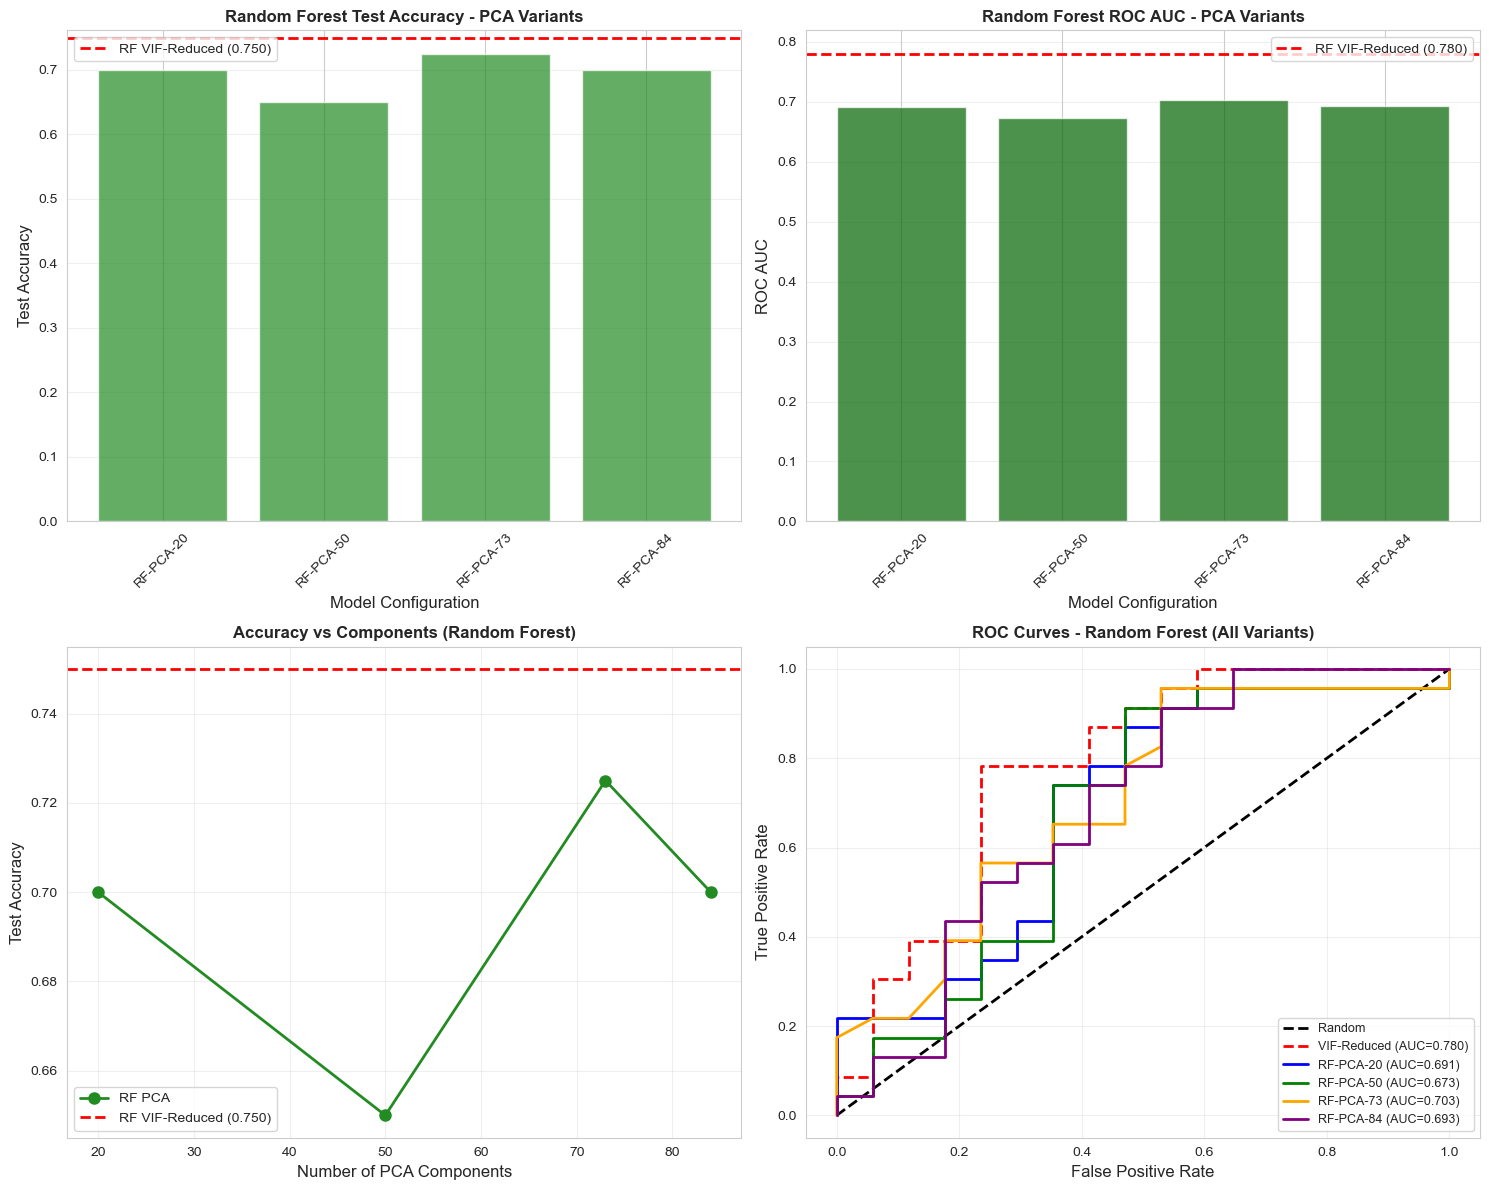

In [33]:
# Visualize Random Forest PCA Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Test Accuracy Comparison
pca_names = [r['Name'] for r in pca_rf_results]
pca_accuracies = [r['test_accuracy'] for r in pca_rf_results]
pca_aucs = [r['roc_auc'] for r in pca_rf_results]
pca_components = [r['n_components'] for r in pca_rf_results]

axes[0, 0].bar(pca_names, pca_accuracies, color='forestgreen', alpha=0.7)
axes[0, 0].axhline(y=accuracy_rf_reduced, color='red', linestyle='--', 
                   label=f'RF VIF-Reduced ({accuracy_rf_reduced:.3f})', linewidth=2)
axes[0, 0].set_xlabel('Model Configuration', fontsize=12)
axes[0, 0].set_ylabel('Test Accuracy', fontsize=12)
axes[0, 0].set_title('Random Forest Test Accuracy - PCA Variants', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. ROC AUC Comparison
axes[0, 1].bar(pca_names, pca_aucs, color='darkgreen', alpha=0.7)
axes[0, 1].axhline(y=auc_rf_reduced, color='red', linestyle='--', 
                   label=f'RF VIF-Reduced ({auc_rf_reduced:.3f})', linewidth=2)
axes[0, 1].set_xlabel('Model Configuration', fontsize=12)
axes[0, 1].set_ylabel('ROC AUC', fontsize=12)
axes[0, 1].set_title('Random Forest ROC AUC - PCA Variants', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Accuracy vs Number of Components
axes[1, 0].plot(pca_components, pca_accuracies, 'o-', color='forestgreen', 
                linewidth=2, markersize=8, label='RF PCA')
axes[1, 0].axhline(y=accuracy_rf_reduced, color='red', linestyle='--', 
                   label=f'RF VIF-Reduced ({accuracy_rf_reduced:.3f})', linewidth=2)
axes[1, 0].set_xlabel('Number of PCA Components', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy', fontsize=12)
axes[1, 0].set_title('Accuracy vs Components (Random Forest)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. ROC Curves for all PCA variants
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[1, 1].plot(fpr_rf_reduced, tpr_rf_reduced, 
                label=f'VIF-Reduced (AUC={auc_rf_reduced:.3f})', 
                linewidth=2, color='red', linestyle='--')

colors = ['blue', 'green', 'orange', 'purple']
for i, result in enumerate(pca_rf_results):
    fpr_temp, tpr_temp, _ = roc_curve(y_test_pca, result['y_pred_proba'])
    axes[1, 1].plot(fpr_temp, tpr_temp, 
                    label=f"{result['Name']} (AUC={result['roc_auc']:.3f})", 
                    linewidth=2, color=colors[i])

axes[1, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 1].set_title('ROC Curves - Random Forest (All Variants)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 13. COMPREHENSIVE MODEL COMPARISON <a id='section14'></a>


In [34]:
# COMPREHENSIVE COMPARISON: ALL MODELS (LOGISTIC REGRESSION + RANDOM FOREST)

print("Comprehensive Model Comparison - Logistic Regression & Random Forest")

# LOGISTIC REGRESSION MODELS
lr_models = {
    'LR-Original': {
        'Model': 'Logistic Regression',
        'n_features': X.shape[1],
        'Test Accuracy': accuracy_lr_best,
        'ROC AUC': auc_lr_best,
        'CV Accuracy': grid_lr.best_score_,
        'Explained Var': 1.0
    },
    'LR-VIF-Reduced': {
        'Model': 'Logistic Regression',
        'n_features': X_reduced.shape[1],
        'Test Accuracy': accuracy_lr_reduced,
        'ROC AUC': auc_lr_reduced,
        'CV Accuracy': grid_lr_reduced.best_score_,
        'Explained Var': 1.0
    }
}

# Add LR PCA models
for r in pca_results:
    lr_models[f"LR-{r['Name']}"] = {
        'Model': 'Logistic Regression',
        'n_features': r['n_components'],
        'Test Accuracy': r['test_accuracy'],
        'ROC AUC': r['roc_auc'],
        'CV Accuracy': r['cv_accuracy'],
        'Explained Var': r['explained_var']
    }

# RANDOM FOREST MODELS
rf_models = {
    'RF-Original': {
        'Model': 'Random Forest',
        'n_features': X.shape[1],
        'Test Accuracy': accuracy_rf_best,
        'ROC AUC': auc_rf_best,
        'CV Accuracy': grid_rf.best_score_,
        'Explained Var': 1.0
    },
    'RF-VIF-Reduced': {
        'Model': 'Random Forest',
        'n_features': X_reduced.shape[1],
        'Test Accuracy': accuracy_rf_reduced,
        'ROC AUC': auc_rf_reduced,
        'CV Accuracy': cv_acc_rf_reduced,
        'Explained Var': 1.0
    }
}

# Add RF PCA models
for r in pca_rf_results:
    rf_models[r['Name']] = {
        'Model': 'Random Forest',
        'n_features': r['n_components'],
        'Test Accuracy': r['test_accuracy'],
        'ROC AUC': r['roc_auc'],
        'CV Accuracy': r['cv_accuracy'],
        'Explained Var': r['explained_var']
    }

# Combine all models
all_models = {**lr_models, **rf_models}

# Create comprehensive comparison dataframe
comparison_all = pd.DataFrame([
    {
        'Model Name': name,
        'Algorithm': info['Model'],
        'n_features': info['n_features'],
        'Test Accuracy': info['Test Accuracy'],
        'ROC AUC': info['ROC AUC'],
        'CV Accuracy': info['CV Accuracy'],
        'Explained Var': info['Explained Var']
    }
    for name, info in all_models.items()
])

# Sort by test accuracy
comparison_all = comparison_all.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\nALL Models Comparison")
print(comparison_all.to_string(index=False))

# Best models
print("Best Models By Metric")
best_accuracy = comparison_all.loc[comparison_all['Test Accuracy'].idxmax()]
best_auc = comparison_all.loc[comparison_all['ROC AUC'].idxmax()]
best_cv = comparison_all.loc[comparison_all['CV Accuracy'].idxmax()]

print(f"\nBest Test Accuracy: {best_accuracy['Model Name']} ({best_accuracy['Test Accuracy']:.3f})")
print(f"  Algorithm: {best_accuracy['Algorithm']}")
print(f"  Features: {best_accuracy['n_features']}")

print(f"\nBest ROC AUC: {best_auc['Model Name']} ({best_auc['ROC AUC']:.3f})")
print(f"  Algorithm: {best_auc['Algorithm']}")
print(f"  Features: {best_auc['n_features']}")

print(f"\nBest CV Accuracy: {best_cv['Model Name']} ({best_cv['CV Accuracy']:.3f})")
print(f"  Algorithm: {best_cv['Algorithm']}")
print(f"  Features: {best_cv['n_features']}")

# Algorithm comparison
print("Algorithm Comparison (Average Performance)")
algo_comparison = comparison_all.groupby('Algorithm').agg({
    'Test Accuracy': ['mean', 'max', 'min'],
    'ROC AUC': ['mean', 'max', 'min'],
    'CV Accuracy': ['mean', 'max', 'min']
})
print(algo_comparison)

Comprehensive Model Comparison - Logistic Regression & Random Forest

ALL Models Comparison
    Model Name           Algorithm  n_features  Test Accuracy  ROC AUC  CV Accuracy  Explained Var
   RF-Original       Random Forest         160          0.750 0.749361     0.751411       1.000000
RF-VIF-Reduced       Random Forest          84          0.750 0.780051     0.783468       1.000000
LR-VIF-Reduced Logistic Regression          84          0.725 0.682864     0.707460       1.000000
     LR-PCA-50 Logistic Regression          50          0.725 0.762148     0.688508       0.821797
     RF-PCA-73       Random Forest          73          0.725 0.703325     0.694355       0.939448
   LR-Original Logistic Regression         160          0.700 0.764706     0.726210       1.000000
     LR-PCA-73 Logistic Regression          73          0.700 0.721228     0.701008       0.939448
     LR-PCA-84 Logistic Regression          84          0.700 0.723785     0.694556       0.969786
     RF-PCA-84   

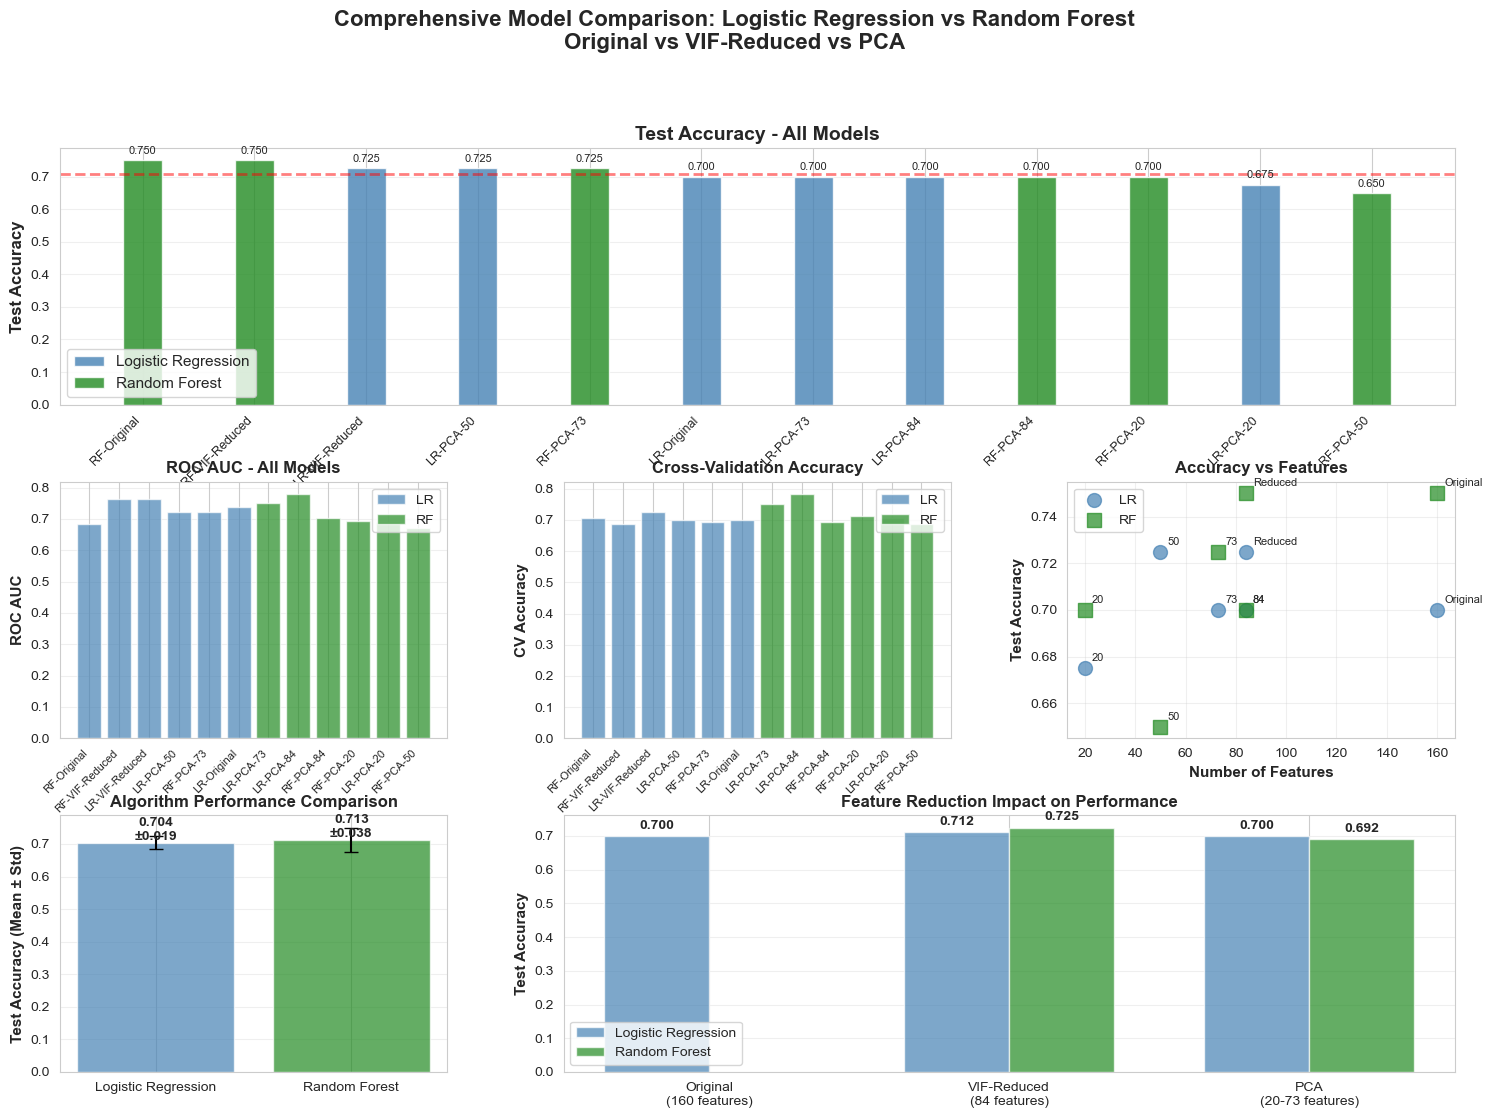

In [35]:
# Visualize comprehensive comparison
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Test Accuracy by Model
ax1 = fig.add_subplot(gs[0, :])
lr_data = comparison_all[comparison_all['Algorithm'] == 'Logistic Regression']
rf_data = comparison_all[comparison_all['Algorithm'] == 'Random Forest']

x = np.arange(len(comparison_all))
width = 0.35

# Use consistent colors for each algorithm
# This makes the legend clear and matches other subplots

# Create bars with different colors for LR and RF
# Get the positions for each model from comparison_all
model_positions = {name: idx for idx, name in enumerate(comparison_all['Model Name'])}

# Create positions for bars based on actual order in comparison_all
lr_positions = [model_positions[name] for name in lr_data['Model Name']]
rf_positions = [model_positions[name] for name in rf_data['Model Name']]


bars1 = ax1.bar(lr_positions, lr_data['Test Accuracy'], width, label='Logistic Regression', color='steelblue', alpha=0.8)
bars2 = ax1.bar(rf_positions, rf_data['Test Accuracy'], width, label='Random Forest', color='forestgreen', alpha=0.8)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy - All Models', fontsize=14, fontweight='bold')
ax1.set_xticks(np.arange(len(comparison_all)))
ax1.set_xticklabels(comparison_all['Model Name'], rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')
ax1.axhline(y=comparison_all['Test Accuracy'].mean(), color='red', linestyle='--',
            linewidth=2, alpha=0.5, label=f'Mean: {comparison_all["Test Accuracy"].mean():.3f}')

# 2. ROC AUC Comparison
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(range(len(lr_data)), lr_data['ROC AUC'], color='steelblue', alpha=0.7, label='LR')
ax2.bar(range(len(lr_data), len(comparison_all)), rf_data['ROC AUC'],
        color='forestgreen', alpha=0.7, label='RF')
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('ROC AUC', fontsize=11, fontweight='bold')
ax2.set_title('ROC AUC - All Models', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(comparison_all)))
ax2.set_xticklabels(comparison_all['Model Name'], rotation=45, ha='right', fontsize=8)
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# 3. CV Accuracy Comparison
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(range(len(lr_data)), lr_data['CV Accuracy'], color='steelblue', alpha=0.7, label='LR')
ax3.bar(range(len(lr_data), len(comparison_all)), rf_data['CV Accuracy'],
        color='forestgreen', alpha=0.7, label='RF')
ax3.set_xlabel('Model', fontsize=11, fontweight='bold')
ax3.set_ylabel('CV Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Cross-Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(comparison_all)))
ax3.set_xticklabels(comparison_all['Model Name'], rotation=45, ha='right', fontsize=8)
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4. Features vs Accuracy
ax4 = fig.add_subplot(gs[1, 2])
ax4.scatter(lr_data['n_features'], lr_data['Test Accuracy'],
           s=100, color='steelblue', alpha=0.7, label='LR', marker='o')
ax4.scatter(rf_data['n_features'], rf_data['Test Accuracy'],
           s=100, color='forestgreen', alpha=0.7, label='RF', marker='s')

# Add labels for each point
for _, row in lr_data.iterrows():
    ax4.annotate(row['Model Name'].split('-')[-1],
                (row['n_features'], row['Test Accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
for _, row in rf_data.iterrows():
    ax4.annotate(row['Model Name'].split('-')[-1],
                (row['n_features'], row['Test Accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Accuracy vs Features', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Algorithm Performance Distribution
ax5 = fig.add_subplot(gs[2, 0])
algo_avg = comparison_all.groupby('Algorithm')['Test Accuracy'].agg(['mean', 'std'])
ax5.bar(algo_avg.index, algo_avg['mean'], yerr=algo_avg['std'],
       color=['steelblue', 'forestgreen'], alpha=0.7, capsize=5)
ax5.set_ylabel('Test Accuracy (Mean ± Std)', fontsize=11, fontweight='bold')
ax5.set_title('Algorithm Performance Comparison', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(algo_avg.iterrows()):
    ax5.text(i, row['mean'], f"{row['mean']:.3f}\n±{row['std']:.3f}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Feature Reduction Impact
ax6 = fig.add_subplot(gs[2, 1:])
# Separate by feature count categories
original = comparison_all[comparison_all['n_features'] == X.shape[1]]
vif_reduced = comparison_all[comparison_all['n_features'] == X_reduced.shape[1]]
pca_models = comparison_all[(comparison_all['n_features'] < X_reduced.shape[1])]

categories = ['Original\n(160 features)', 'VIF-Reduced\n(84 features)', 'PCA\n(20-73 features)']
lr_means = [
    original[original['Algorithm'] == 'Logistic Regression']['Test Accuracy'].mean() if len(original[original['Algorithm'] == 'Logistic Regression']) > 0 else 0,
    vif_reduced[vif_reduced['Algorithm'] == 'Logistic Regression']['Test Accuracy'].mean() if len(vif_reduced[vif_reduced['Algorithm'] == 'Logistic Regression']) > 0 else 0,
    pca_models[pca_models['Algorithm'] == 'Logistic Regression']['Test Accuracy'].mean() if len(pca_models[pca_models['Algorithm'] == 'Logistic Regression']) > 0 else 0
]
rf_means = [
    0,  # No RF with original features
    vif_reduced[vif_reduced['Algorithm'] == 'Random Forest']['Test Accuracy'].mean() if len(vif_reduced[vif_reduced['Algorithm'] == 'Random Forest']) > 0 else 0,
    pca_models[pca_models['Algorithm'] == 'Random Forest']['Test Accuracy'].mean() if len(pca_models[pca_models['Algorithm'] == 'Random Forest']) > 0 else 0
]

x_cat = np.arange(len(categories))
width = 0.35

bars1 = ax6.bar(x_cat - width/2, lr_means, width, label='Logistic Regression',
               color='steelblue', alpha=0.7)
bars2 = ax6.bar(x_cat + width/2, rf_means, width, label='Random Forest',
               color='forestgreen', alpha=0.7)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax6.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax6.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

ax6.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Feature Reduction Impact on Performance', fontsize=12, fontweight='bold')
ax6.set_xticks(x_cat)
ax6.set_xticklabels(categories, fontsize=10)
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3, axis='y')

plt.suptitle('Comprehensive Model Comparison: Logistic Regression vs Random Forest\nOriginal vs VIF-Reduced vs PCA',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [36]:
lr_avg_acc = comparison_all[comparison_all['Algorithm'] == 'Logistic Regression']['Test Accuracy'].mean()
rf_avg_acc = comparison_all[comparison_all['Algorithm'] == 'Random Forest']['Test Accuracy'].mean()

print(f"\n2. Algorithm Comparison:")
print(f"   - Logistic Regression Average Accuracy: {lr_avg_acc:.3f}")
print(f"   - Random Forest Average Accuracy: {rf_avg_acc:.3f}")
if rf_avg_acc > lr_avg_acc:
    print(f"   - Random Forest outperforms LR by {(rf_avg_acc - lr_avg_acc):.3f} on average")
else:
    print(f"   - Logistic Regression outperforms RF by {(lr_avg_acc - rf_avg_acc):.3f} on average")

# VIF impact
lr_original_acc = comparison_all[comparison_all['Model Name'] == 'LR-Original']['Test Accuracy'].values[0]
lr_vif_acc = comparison_all[comparison_all['Model Name'] == 'LR-VIF-Reduced']['Test Accuracy'].values[0]
rf_vif_acc = comparison_all[comparison_all['Model Name'] == 'RF-VIF-Reduced']['Test Accuracy'].values[0]

print(f"\n3. Vif Feature Reduction Impact:")
print(f"   - Original: {X.shape[1]} features")
print(f"   - VIF-Reduced: {X_reduced.shape[1]} features ({(X_reduced.shape[1]/X.shape[1])*100:.1f}% of original)")
print(f"   - LR: {lr_original_acc:.3f} → {lr_vif_acc:.3f} (change: {lr_vif_acc - lr_original_acc:+.4f})")
print(f"   - RF: N/A → {rf_vif_acc:.3f} (VIF-Reduced only)")

# PCA impact
print(f"\n4. Pca Performance:")
pca_lr_models = [r for r in pca_results]
pca_rf_models = pca_rf_results

if pca_lr_models:
    best_pca_lr = max(pca_lr_models, key=lambda x: x['test_accuracy'])
    print(f"   - Best LR-PCA: {best_pca_lr['Name']} with {best_pca_lr['n_components']} components")
    print(f"     Accuracy: {best_pca_lr['test_accuracy']:.3f}, Variance: {best_pca_lr['explained_var']:.1%}")

if pca_rf_models:
    best_pca_rf = max(pca_rf_models, key=lambda x: x['test_accuracy'])
    print(f"   - Best RF-PCA: {best_pca_rf['Name']} with {best_pca_rf['n_components']} components")
    print(f"     Accuracy: {best_pca_rf['test_accuracy']:.3f}, Variance: {best_pca_rf['explained_var']:.1%}")

# Feature efficiency
print(f"\n5. Feature Efficiency:")
for name in ['LR-PCA-20', 'RF-PCA-20']:
    if name in comparison_all['Model Name'].values:
        model_data = comparison_all[comparison_all['Model Name'] == name].iloc[0]
        feature_reduction = (1 - model_data['n_features'] / X.shape[1]) * 100
        print(f"   - {name}:")
        print(f"     {model_data['n_features']} features ({feature_reduction:.1f}% reduction)")
        print(f"     Accuracy: {model_data['Test Accuracy']:.3f}")

pca_20_models = comparison_all[comparison_all['n_features'] == 20].sort_values('Test Accuracy', ascending=False)
if len(pca_20_models) > 0:
    best_pca_20 = pca_20_models.iloc[0]
    print(f"   Use {best_pca_20['Model Name']} ({best_pca_20['Algorithm']})")
    print(f"   Only 20 features (87.5% reduction)")
    print(f"   Accuracy: {best_pca_20['Test Accuracy']:.3f}")

print("\n3. For Interpretability:")
print(f"   Use LR-VIF-Reduced (Logistic Regression)")
print(f"   Linear model with {X_reduced.shape[1]} interpretable features")
print(f"   Accuracy: {lr_vif_acc:.3f}")

print("\n4. For Robustness:")
print(f"   Use Random Forest models")
print(f"   Less sensitive to feature scaling and multicollinearity")
print(f"   Average accuracy: {rf_avg_acc:.3f}")



2. Algorithm Comparison:
   - Logistic Regression Average Accuracy: 0.704
   - Random Forest Average Accuracy: 0.713
   - Random Forest outperforms LR by 0.008 on average

3. Vif Feature Reduction Impact:
   - Original: 160 features
   - VIF-Reduced: 84 features (52.5% of original)
   - LR: 0.700 → 0.725 (change: +0.0250)
   - RF: N/A → 0.750 (VIF-Reduced only)

4. Pca Performance:
   - Best LR-PCA: PCA-50 with 50 components
     Accuracy: 0.725, Variance: 82.2%
   - Best RF-PCA: RF-PCA-73 with 73 components
     Accuracy: 0.725, Variance: 93.9%

5. Feature Efficiency:
   - LR-PCA-20:
     20 features (87.5% reduction)
     Accuracy: 0.675
   - RF-PCA-20:
     20 features (87.5% reduction)
     Accuracy: 0.700
   Use RF-PCA-20 (Random Forest)
   Only 20 features (87.5% reduction)
   Accuracy: 0.700

3. For Interpretability:
   Use LR-VIF-Reduced (Logistic Regression)
   Linear model with 84 interpretable features
   Accuracy: 0.725

4. For Robustness:
   Use Random Forest models
   Le

---
## 14. Question 2 Analysis <a id='section15'></a>


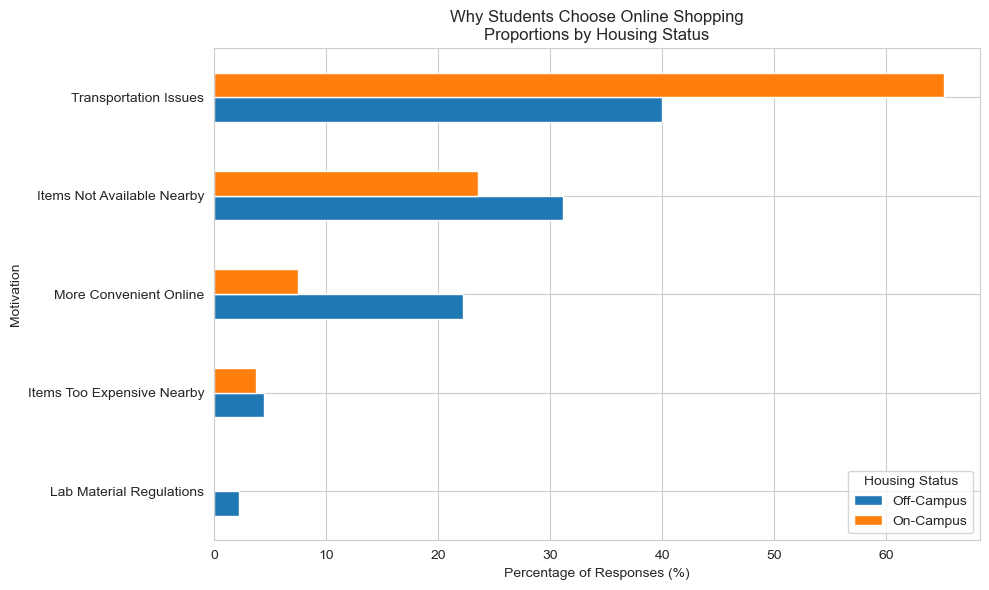

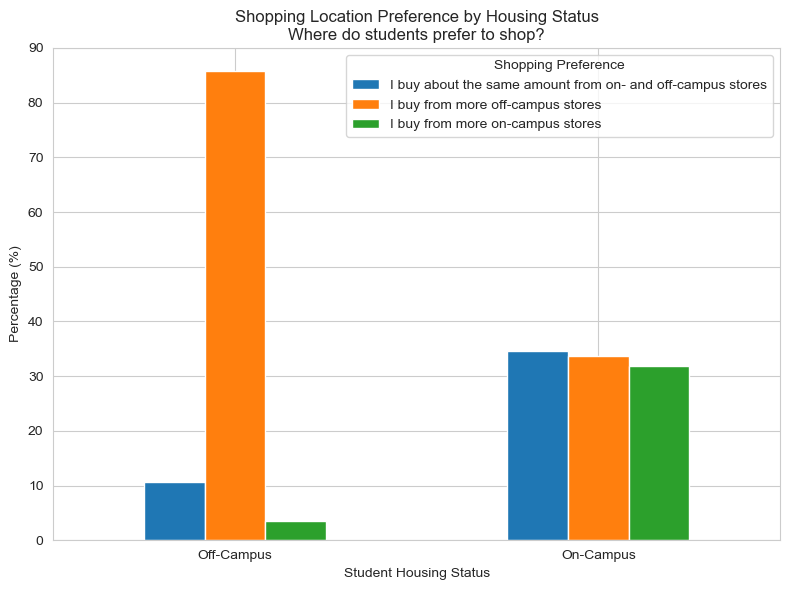

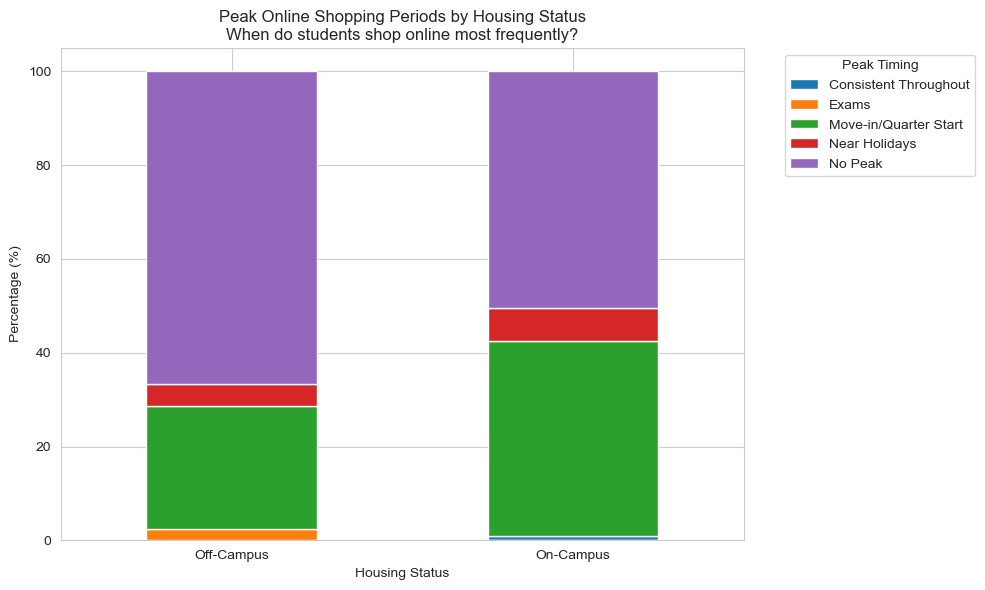

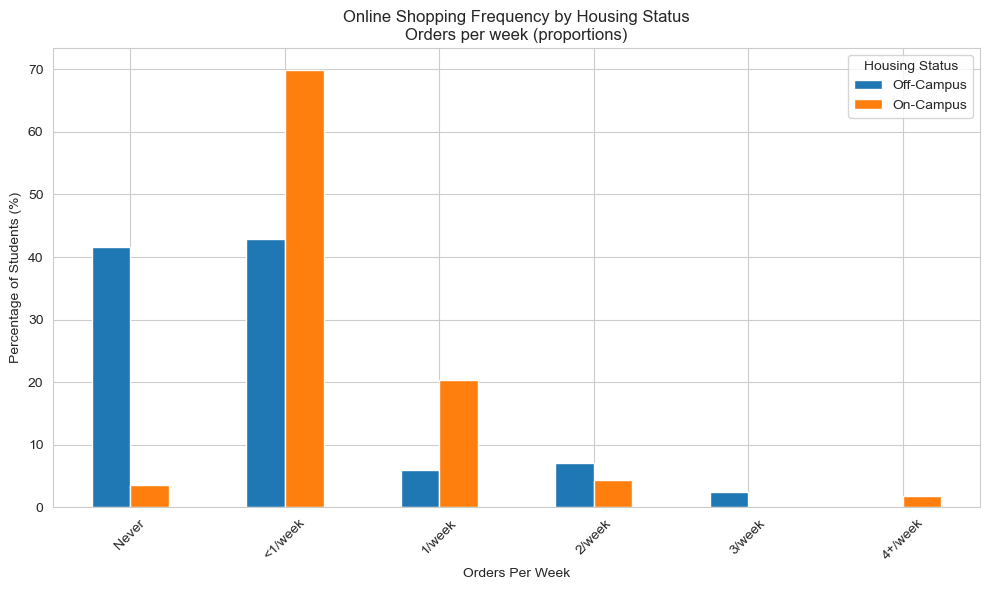

In [37]:
# Read the data
shopping = pd.read_csv("data.csv")

# Rename columns for easier access
shopping.columns = [
    'timestamp', 'student_status', 'housing', 'primary_access', 'orders_per_week',
    'items_per_order', 'cardboard_disposal', 'plastic_disposal', 'item_types',
    'most_delivered_items', 'peak_package_freq', 'why_deliver', 'instore_items',
    'most_instore_items', 'on_off_campus', 'shopping_options', 'items_wanted',
    'news_source', 'other_comments'
]

# Shopping motivation proportions by housing status
def classify_housing(housing):
    if pd.isna(housing):
        return "Other"
    housing_str = str(housing).lower()
    if "on-campus" in housing_str or "on campus" in housing_str:
        return "On-Campus"
    elif "off-campus" in housing_str or "off campus" in housing_str:
        return "Off-Campus"
    else:
        return "Other"

def classify_delivery_reason(why_deliver):
    if pd.isna(why_deliver) or why_deliver == "NA":
        return None
    reason_str = str(why_deliver).lower()
    if "transportation" in reason_str:
        return "Transportation Issues"
    elif "not offered" in reason_str:
        return "Items Not Available Nearby"
    elif "too expensive" in reason_str:
        return "Items Too Expensive Nearby"
    elif "convenient" in reason_str:
        return "More Convenient Online"
    elif "lab materials" in reason_str:
        return "Lab Material Regulations"
    elif "shipping is free" in reason_str or "free shipping" in reason_str:
        return "Free Shipping"
    elif "discount" in reason_str:
        return "Online Discount"
    else:
        return why_deliver

online_reasons = shopping.copy()
online_reasons['housing_simple'] = online_reasons['housing'].apply(classify_housing)
online_reasons['why_deliver_short'] = online_reasons['why_deliver'].apply(classify_delivery_reason)
online_reasons = online_reasons[online_reasons['why_deliver_short'].notna()]

online_reasons_grouped = online_reasons.groupby(['housing_simple', 'why_deliver_short']).size().reset_index(name='count')
online_reasons_grouped['proportion'] = online_reasons_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
online_reasons_grouped['percentage'] = online_reasons_grouped['proportion'] * 100

# Plot 1: Why Students Choose Online Shopping
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data = online_reasons_grouped.pivot(index='why_deliver_short', columns='housing_simple', values='percentage')
if not pivot_data.empty:
    pivot_data = pivot_data.fillna(0)
    # Sort by average percentage across all housing types
    pivot_data['avg'] = pivot_data.mean(axis=1)
    pivot_data = pivot_data.sort_values('avg', ascending=True).drop('avg', axis=1)
    pivot_data.plot(kind='barh', ax=ax, figsize=(10, 6))
    plt.title("Why Students Choose Online Shopping\nProportions by Housing Status")
    plt.xlabel("Percentage of Responses (%)")
    plt.ylabel("Motivation")
    plt.legend(title="Housing Status")
    plt.tight_layout()
plt.show()

# Shopping preferences by housing status
shopping_location = shopping.copy()
shopping_location['housing_simple'] = shopping_location['housing'].apply(classify_housing)
shopping_location_grouped = shopping_location.groupby(['housing_simple', 'on_off_campus']).size().reset_index(name='count')
shopping_location_grouped['proportion'] = shopping_location_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
shopping_location_grouped['percentage'] = shopping_location_grouped['proportion'] * 100

# Plot 2: Shopping Location Preference
fig, ax = plt.subplots(figsize=(8, 6))
pivot_location = shopping_location_grouped.pivot(index='housing_simple', columns='on_off_campus', values='percentage')
if not pivot_location.empty:
    pivot_location = pivot_location.fillna(0)
    pivot_location.plot(kind='bar', ax=ax, figsize=(8, 6))
    plt.title("Shopping Location Preference by Housing Status\nWhere do students prefer to shop?")
    plt.xlabel("Student Housing Status")
    plt.ylabel("Percentage (%)")
    plt.legend(title="Shopping Preference")
    plt.xticks(rotation=0)
    plt.tight_layout()
plt.show()

# Peak shopping times
def classify_peak_time(peak_package_freq):
    if pd.isna(peak_package_freq):
        return "No Peak"
    peak_lower = str(peak_package_freq).lower()
    if any(word in peak_lower for word in ["move", "quarter", "beginning", "start"]):
        return "Move-in/Quarter Start"
    elif any(word in peak_lower for word in ["holiday", "christmas", "december"]):
        return "Near Holidays"
    elif peak_lower in ["no", "nope", "none", "not really", "not necessarily"]:
        return "No Peak"
    elif any(word in peak_lower for word in ["exam", "midterm"]):
        return "Exams"
    elif "consistent" in peak_lower:
        return "Consistent Throughout"
    else:
        return "No Peak"

peak_times = shopping.copy()
peak_times['housing_simple'] = peak_times['housing'].apply(classify_housing)
peak_times['peak_short'] = peak_times['peak_package_freq'].apply(classify_peak_time)
peak_times_grouped = peak_times.groupby(['housing_simple', 'peak_short']).size().reset_index(name='count')
peak_times_grouped['proportion'] = peak_times_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
peak_times_grouped['percentage'] = peak_times_grouped['proportion'] * 100

# Plot 3: Peak Shopping Periods
fig, ax = plt.subplots(figsize=(10, 6))
pivot_peak = peak_times_grouped.pivot(index='housing_simple', columns='peak_short', values='percentage')
if not pivot_peak.empty:
    pivot_peak = pivot_peak.fillna(0)
    pivot_peak.plot(kind='bar', stacked=True, ax=ax, figsize=(10, 6))
    plt.title("Peak Online Shopping Periods by Housing Status\nWhen do students shop online most frequently?")
    plt.xlabel("Housing Status")
    plt.ylabel("Percentage (%)")
    plt.legend(title="Peak Timing", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
plt.show()

# Order frequency by housing status
def classify_order_freq(orders_per_week):
    if pd.isna(orders_per_week):
        return "Unknown"
    order_str = str(orders_per_week).lower()
    if "never" in order_str:
        return "Never"
    elif "<1" in order_str or "less than 1" in order_str:
        return "<1/week"
    elif order_str == "1" or "1 package" in order_str:
        return "1/week"
    elif order_str == "2" or "2 packages" in order_str:
        return "2/week"
    elif order_str == "3" or "3 packages" in order_str:
        return "3/week"
    elif "4" in order_str or "more than 3" in order_str:
        return "4+/week"
    else:
        return order_str

order_freq = shopping.copy()
order_freq['housing_simple'] = order_freq['housing'].apply(classify_housing)
order_freq['orders_short'] = order_freq['orders_per_week'].apply(classify_order_freq)
order_freq_grouped = order_freq.groupby(['housing_simple', 'orders_short']).size().reset_index(name='count')
order_freq_grouped['proportion'] = order_freq_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
order_freq_grouped['percentage'] = order_freq_grouped['proportion'] * 100

# Plot 4: Shopping Frequency
fig, ax = plt.subplots(figsize=(10, 6))
pivot_freq = order_freq_grouped.pivot(index='orders_short', columns='housing_simple', values='percentage')
if not pivot_freq.empty:
    pivot_freq = pivot_freq.fillna(0)
    # Reorder to logical order
    order_mapping = {"Never": 0, "<1/week": 1, "1/week": 2, "2/week": 3, "3/week": 4, "4+/week": 5}
    pivot_freq['sort_key'] = pivot_freq.index.map(lambda x: order_mapping.get(x, 99))
    pivot_freq = pivot_freq.sort_values('sort_key').drop('sort_key', axis=1)
    pivot_freq.plot(kind='bar', ax=ax, figsize=(10, 6))
    plt.title("Online Shopping Frequency by Housing Status\nOrders per week (proportions)")
    plt.xlabel("Orders Per Week")
    plt.ylabel("Percentage of Students (%)")
    plt.legend(title="Housing Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()